In [7]:
!pip install torcheval
!pip install scikit-learn

   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 960.0 kB/s eta 0:00:12
   -- ------------------------------------- 0.5/10.6 MB 6.7 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.6 MB 11.6 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/10.6 MB 12.8 MB/s eta 0:00:01
   ---------- ----------------------------- 2.8/10.6 MB 12.7 MB/s eta 0:00:01
   ------------- -------------------------- 3.6/10.6 MB 13.5 MB/s eta 0:00:01
   ---------------- ----------------------- 4.5/10.6 MB 14.4 MB/s eta 0:00:01
   -------------------- ------------------- 5.4/10.6 MB 14.9 MB/s eta 0:00:01
   ------------------------ --------------- 6.5/10.6 MB 15.9 MB/s eta 0:00:01
   --------------------------- ------------ 7.4/10.6 MB 16.3 MB/s eta 0:00:01
   ------------------------------ --------- 8.2/10.6 MB 16.4 MB/s eta 0:00:01
   ---------------------------------- ----- 9.0/10.6 MB 16.5 MB/s eta 0:

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Paths & URLs

import os

# Enable CUDA stacktrace reporting for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['PYTORCH_NO_CUDA_MEMORY_CACHING'] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Directorio base
#PATH_BASE = '/content/drive/MyDrive/proximity'
#PATH_BASE = 'C:\\Users\\User\\Documents\\Proyecto Proximity'
PATH_BASE = 'E:\\files\\Documents\\Proyecto Proximity'

# Data release actual
DR70_PATH = os.path.join(PATH_BASE, 'DR70')
DR70_CT_PATH = os.path.join(DR70_PATH, 'datalake_sorted')
DR70_LABELS_PATH = os.path.join(DR70_PATH, 'labels.csv')

# Data release 176
DR176_PATH = os.path.join(PATH_BASE, 'DR176')
DR176_CT_PATH = os.path.join(DR176_PATH, 'DR176_studies')
DR176_LABELS_PATH = os.path.join(PATH_BASE, 'reports_with_label.csv')


# Data release 217
DR217_PATH = os.path.join(PATH_BASE, 'DR217')
DR217_CT_PATH = os.path.join(DR217_PATH, 'DR217_studies')
DR217_LABELS_PATH = os.path.join(DR217_PATH, 'DR217_labels.csv')
# Used for normalization of the intensity values for each CT
DR217_CT_HISTOGRAM_LANDMARKS_PATH = os.path.join(DR217_PATH, 'DR217_histogram_landmarks.npy')
# Embeddings ResNet18 DR217
DR217_RESNET_EMBEDDINGS_PATH = os.path.join(DR217_PATH, 'DR217_resnet18_embeddings')

# CTs in Nibabel format
CT_NIBABEL_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs')

# Embeddings visuales de CTs
#CT_EMBEDDINGS_PATH = DATA_RELEASE_PATH + '/visual_embeddings'


# Etiquetas de los CTs del data release actual
#CT_LABELS_CSV_PATH = DATA_RELEASE_PATH + '/labels.csv'

# Data release (CTs + etiquetas) organizados en un DataFrame
#CT_DATASET_DF_HDF_PATH = os.path.join(PATH_BASE, 'dataset_df.h5')
#CT_DATASET_DF_PICKLE_PATH = os.path.join(PATH_BASE, 'dataset_df.pickle')

# URLs de modelos visuales
#RESNET18_URL = 'microsoft/resnet-18'

# Path que contiene los resnet50 embeddings de CTs del data release actual
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18')
#CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'reshaped_averaged')

# Path de modelos entrenados en base a tripletas
TRIPLET_MODELS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets')
TRIPLET_CHECKPOINTS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'triplets', 'checkpoints')

# Path de modelos entrenados con clasificacion
CLASSIFICATION_MODELS_PATH = os.path.join(PATH_BASE, 'retrieval_models', 'clasification')
CLASSIFICATION_CHECKPOINTS_PATH = os.path.join(CLASSIFICATION_MODELS_PATH, 'checkpoints')

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torchio as tio
from torch.utils.data import Dataset, random_split, RandomSampler, BatchSampler
from scipy.spatial.distance import hamming
import random
import logging

# Set seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

logging.basicConfig(level=logging.INFO)

class ProximityCTDataset(tio.SubjectsDataset):
    def __init__(self, ct_base_path, ct_image_ids, ct_labels_path):
        
        self.labels_df = pd.read_csv(
            ct_labels_path, 
            header=0, 
            #index_col=0, 
            dtype={'CT': str, 'condensacion': int, 'nodulos': int, 'quistes': int}
        )
        
        # Mark those samples that have non-binary label values as not valid
        self.labels_df['labels_are_valid'] = self.labels_df.apply(self._determine_valid_labels, axis=1)

        s_list = []
        for s_id in ct_image_ids:
            label_attribs = self._get_ct_label_data(s_id)
            s = tio.Subject(
                t1 = tio.ScalarImage(os.path.join(ct_base_path, s_id)),
                image_path = os.path.join(ct_base_path, s_id),
                **label_attribs
            )
            s_list.append(s)

        # Transforms and augmentations to apply to images in the dataset
        s_transforms = tio.Compose([
            tio.ToCanonical(),
            tio.Resample(3),
            tio.CropOrPad(target_shape=(130, 130, 84), padding_mode='minimum'),
            tio.RescaleIntensity(out_min_max=(0, 1)),
            tio.ZNormalization() # TODO: apply exact z-norm required by ResNet-18
            
        ])
        '''
        s_transforms = tio.Compose([
            tio.ToCanonical(),
            tio.Resample(1),
            tio.CropOrPad(target_shape=(290, 290, 249), padding_mode='minimum'),
            tio.RescaleIntensity(out_min_max=(0, 1)),
            tio.ZNormalization() # TODO: apply exact z-norm required by ResNet-18
            
        ])
        '''

        # Filter out those samples with invalid labels
        s_list = [s for s in s_list if s['labels_are_valid']]
        
        super().__init__(s_list, transform=s_transforms, load_getitem=False)
        
    def _determine_valid_labels(self, row):
        if (row['condensacion'] == 1 or row['condensacion'] == 0) \
        and (row['nodulos'] == 1 or row['nodulos'] == 0) \
        and (row['quistes'] == 1 or row['quistes'] == 0):
            return True
        return False

    def _get_ct_label_data(self, ct_code):
        result = self.labels_df.loc[self.labels_df['CT'] == ct_code+'AN'].to_dict('records')
        if result:
            r = result[0]
            r['labels_as_vector'] = self._get_label_vector(r)
            return r
        else:
            return {'labels_are_valid': False}

    def _get_label_vector(self, labels_dict):
        c = labels_dict['condensacion']
        n = labels_dict['nodulos']
        q = labels_dict['quistes']
        return [c, n, q]

In [4]:
from torch.utils.data import random_split, DataLoader
import multiprocessing

num_workers = multiprocessing.cpu_count()

training_split_ratio = 0.7

subject_list = [dirname for dirname in os.listdir(DR217_CT_PATH)]

num_subjects = len(subject_list)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = (num_training_subjects, num_validation_subjects)

training_subjects, validation_subjects = torch.utils.data.random_split(subject_list, num_split_subjects)

dataset = ProximityCTDataset(DR217_CT_PATH, subject_list, DR217_LABELS_PATH)

training_set = ProximityCTDataset(DR217_CT_PATH, training_subjects, DR217_LABELS_PATH)

validation_set = ProximityCTDataset(DR217_CT_PATH, validation_subjects, DR217_LABELS_PATH)

print('Training set size:', len(training_set))
print('Validation set size:', len(validation_set))

Training set size: 148
Validation set size: 65


In [5]:
'''
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

'''

"\nfrom torchvision.datasets import MNIST\nfrom torchvision import transforms\n\nmean, std = 0.1307, 0.3081\n\ntrain_dataset = MNIST('../data/MNIST', train=True, download=True,\n                             transform=transforms.Compose([\n                                 transforms.ToTensor(),\n                                 transforms.Normalize((mean,), (std,))\n                             ]))\ntest_dataset = MNIST('../data/MNIST', train=False, download=True,\n                            transform=transforms.Compose([\n                                transforms.ToTensor(),\n                                transforms.Normalize((mean,), (std,))\n                            ]))\nn_classes = 10\n\n"

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

proximity_vector_labels = [[0,0,0], [1,0,0], [0,1,0], [0,0,1], [1,0,1], [1,1,0], [0,1,1], [1,1,1]]
proximity_classes = ['(s/a)', 'c', 'n', 'q', 'c+n', 'c+q', 'n+q', 'c+n+q']
proximity_colors = ['#000000', '#ff0000', '#00ff00', '#0000ff',
              '#ff00ff', '#ffff00', '#00ffff', '#ffffff']

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.set_facecolor('#D1D1D1')
    xlim = (embeddings[:, 0].min(), embeddings[:, 0].max())
    xradius = (xlim[1] - xlim[0]) / 2
    xcenter = xlim[0] + xradius
    xlim = (xcenter - 1.1*xradius, xcenter + 1.1*xradius)
    ylim = (embeddings[:, 1].min(), embeddings[:, 1].max())
    yradius = (ylim[1] - ylim[0]) / 2
    ycenter = ylim[0] + yradius
    ylim = (ycenter - 1.1*yradius, ycenter + 1.1*yradius)
    for i in range(len(proximity_vector_labels)):
        #inds = np.where(targets==i)[0]
        new_mask = [(t == proximity_vector_labels[i]).all() for t in targets]
        #plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
        #embeddings_x = (embeddings[new_mask,0] - embeddings[new_mask,0].min()) / (embeddings[new_mask,0].max() - embeddings[new_mask,0].min())
        #embeddings_y = (embeddings[new_mask,1] - embeddings[new_mask,1].min()) / (embeddings[new_mask,1].max() - embeddings[new_mask,1].min())
        #plt.scatter(embeddings_x, embeddings_y, alpha=0.5, edgecolors=proximity_colors[i], color=proximity_colors[i])
        plt.scatter(embeddings[new_mask,0], embeddings[new_mask,1], alpha=0.6, edgecolors=proximity_colors[i], color=proximity_colors[i])
        
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(proximity_classes)
    plt.show()

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros((len(dataloader.dataset), 3))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target
            k += len(images)
            #break
    print(embeddings)
    print(labels)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [5]:
from datasets import ProximityCTEmbeddingDataset
from pathlib import Path
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from trainer import fit
import numpy as np
import random

cuda = torch.cuda.is_available()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

def collate(batch):
    data = []
    labels = []
    for s in batch:
        data.append(s['t1']['data'].squeeze(0))
        labels.append(s['labels_as_vector'])
    return torch.stack(data), torch.tensor(labels, dtype=torch.float32)

def collate_embedding(batch):
    data = []
    labels = []
    for s in batch:
        data.append(torch.tensor(s[0]))
        labels.append(s[1])
    return torch.stack(data), torch.tensor(labels, dtype=torch.float32)

training_split_ratio = 0.7

embeddings_files_list = sorted(Path(DR217_RESNET_EMBEDDINGS_PATH).glob('*.npz'))

# For faster testing: extract a sample from the dataset
#embeddings_files_list = random.sample(embeddings_files_list, len(embeddings_files_list) // 2)

num_subjects = len(embeddings_files_list)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_data = (num_training_subjects, num_validation_subjects)

training_data_paths, validation_data_paths = torch.utils.data.random_split(embeddings_files_list, num_split_data)

full_set = ProximityCTEmbeddingDataset(embeddings_files_list)
training_set = ProximityCTEmbeddingDataset(training_data_paths)
validation_set = ProximityCTEmbeddingDataset(validation_data_paths)

dataset_labels = full_set.labels
loss_weights = (dataset_labels.T == 0).sum(axis=1)/ (dataset_labels.T.sum(axis=1) + 1e-6)
loss_weights = torch.tensor(loss_weights).cuda()
print('Class weight factor:', loss_weights)

del full_set

# Set up data loaders
n_classes = 3
batch_size = 32
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, collate_fn=collate_embedding, **kwargs)
test_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate_embedding, **kwargs)

# Set up the network and training parameters
from networks import CTPreEmbeddedModel, ClassificationNet
from metrics import ClassificationReport, BinaryAccuracyMetric, BinaryRecallMetric, BinaryF1ScoreMetric, AccumulatedAccuracyMetric

embedding_net = CTPreEmbeddedModel(embedding_size=128)
model = ClassificationNet(embedding_net, embedding_size=128, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight=loss_weights)


#lr = 5e-6
#optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99, weight_decay=1e-7)
scheduler = lr_scheduler.StepLR(optimizer, 999, gamma=0.5, last_epoch=-1)
n_epochs = 100
log_interval = 4

print('Training set size:', len(training_set))
print('Validation set size:', len(validation_set))

Class weight factor: tensor([ 2.8727,  0.9541, 11.5294], device='cuda:0', dtype=torch.float64)
Training set size: 149
Validation set size: 64


In [6]:
fit(
    train_loader, 
    test_loader, 
    model, 
    loss_fn, 
    optimizer, 
    scheduler, 
    n_epochs, 
    cuda, 
    log_interval,
    CLASSIFICATION_CHECKPOINTS_PATH,
    #metrics=[BinaryAccuracyMetric(), BinaryRecallMetric(), BinaryF1ScoreMetric()],
    metrics=[ClassificationReport()]
)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 1/100. Train set:
	Average loss: 1.0327
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      1.00      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.55       132
 samples avg       0.30      0.72      0.41       132

Epoch: 1/100. Validation set:
	Average loss: 0.9032
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 2/100. Train set:
	Average loss: 1.0232
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      1.00      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.55       132
 samples avg       0.30      0.72      0.41       132

Epoch: 2/100. Validation set:
	Average loss: 0.9033
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 3/100. Train set:
	Average loss: 1.0301
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      1.00      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.55       132
 samples avg       0.30      0.72      0.41       132

Epoch: 3/100. Validation set:
	Average loss: 0.9034
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 4/100. Train set:
	Average loss: 1.0264
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.99      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.99      0.45       132
   macro avg       0.29      1.00      0.43       132
weighted avg       0.39      0.99      0.55       132
 samples avg       0.29      0.72      0.41       132

Epoch: 4/100. Validation set:
	Average loss: 0.9035
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 5/100. Train set:
	Average loss: 1.0307
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      1.00      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.55       132
 samples avg       0.30      0.72      0.41       132

Epoch: 5/100. Validation set:
	Average loss: 0.9037
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 6/100. Train set:
	Average loss: 1.0192
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.53      1.00      0.69        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.56       132
 samples avg       0.30      0.72      0.41       132

Epoch: 6/100. Validation set:
	Average loss: 0.9039
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 7/100. Train set:
	Average loss: 1.0449
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.99      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.99      0.45       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      0.99      0.55       132
 samples avg       0.30      0.72      0.41       132

Epoch: 7/100. Validation set:
	Average loss: 0.9042
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 8/100. Train set:
	Average loss: 1.0387
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      1.00      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.55       132
 samples avg       0.30      0.72      0.41       132

Epoch: 8/100. Validation set:
	Average loss: 0.9044
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 9/100. Train set:
	Average loss: 1.0390
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.97      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.98      0.45       132
   macro avg       0.30      0.99      0.43       132
weighted avg       0.40      0.98      0.55       132
 samples avg       0.29      0.71      0.41       132

Epoch: 9/100. Validation set:
	Average loss: 0.9047
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62      0

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 10/100. Train set:
	Average loss: 1.0372
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      1.00      0.69        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.55       132
 samples avg       0.30      0.72      0.41       132

Epoch: 10/100. Validation set:
	Average loss: 0.9052
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 11/100. Train set:
	Average loss: 1.0293
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.53      1.00      0.69        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      1.00      0.46       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      1.00      0.56       132
 samples avg       0.30      0.72      0.41       132

Epoch: 11/100. Validation set:
	Average loss: 0.9056
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 12/100. Train set:
	Average loss: 1.0238
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.97      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.98      0.45       132
   macro avg       0.30      0.99      0.43       132
weighted avg       0.40      0.98      0.55       132
 samples avg       0.30      0.71      0.41       132

Epoch: 12/100. Validation set:
	Average loss: 0.9061
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 13/100. Train set:
	Average loss: 1.0326
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.99      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.99      0.45       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      0.99      0.55       132
 samples avg       0.29      0.72      0.41       132

Epoch: 13/100. Validation set:
	Average loss: 0.9066
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 14/100. Train set:
	Average loss: 1.0375
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.99      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.99      0.45       132
   macro avg       0.30      1.00      0.43       132
weighted avg       0.40      0.99      0.55       132
 samples avg       0.29      0.72      0.41       132

Epoch: 14/100. Validation set:
	Average loss: 0.9071
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 15/100. Train set:
	Average loss: 1.0302
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.96      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.98      0.45       132
   macro avg       0.29      0.99      0.42       132
weighted avg       0.39      0.98      0.54       132
 samples avg       0.29      0.70      0.40       132

Epoch: 15/100. Validation set:
	Average loss: 0.9076
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 16/100. Train set:
	Average loss: 1.0192
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.50      0.94      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.96      0.44       132
   macro avg       0.29      0.98      0.42       132
weighted avg       0.39      0.96      0.53       132
 samples avg       0.29      0.69      0.40       132

Epoch: 16/100. Validation set:
	Average loss: 0.9082
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 17/100. Train set:
	Average loss: 1.0326
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.95      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.97      0.45       132
   macro avg       0.29      0.98      0.42       132
weighted avg       0.40      0.97      0.54       132
 samples avg       0.29      0.70      0.40       132

Epoch: 17/100. Validation set:
	Average loss: 0.9087
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 18/100. Train set:
	Average loss: 1.0227
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.96      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.98      0.45       132
   macro avg       0.29      0.99      0.42       132
weighted avg       0.40      0.98      0.54       132
 samples avg       0.29      0.71      0.40       132

Epoch: 18/100. Validation set:
	Average loss: 0.9092
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 19/100. Train set:
	Average loss: 1.0145
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.53      0.95      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.97      0.45       132
   macro avg       0.30      0.98      0.43       132
weighted avg       0.41      0.97      0.55       132
 samples avg       0.29      0.71      0.40       132

Epoch: 19/100. Validation set:
	Average loss: 0.9096
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 20/100. Train set:
	Average loss: 1.0225
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.50      0.91      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.95      0.44       132
   macro avg       0.29      0.97      0.42       132
weighted avg       0.39      0.95      0.53       132
 samples avg       0.29      0.69      0.39       132

Epoch: 20/100. Validation set:
	Average loss: 0.9100
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 21/100. Train set:
	Average loss: 1.0209
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.53      0.95      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.97      0.45       132
   macro avg       0.30      0.98      0.43       132
weighted avg       0.40      0.97      0.55       132
 samples avg       0.29      0.70      0.40       132

Epoch: 21/100. Validation set:
	Average loss: 0.9104
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 22/100. Train set:
	Average loss: 1.0230
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.94      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.96      0.45       132
   macro avg       0.30      0.98      0.42       132
weighted avg       0.40      0.96      0.54       132
 samples avg       0.29      0.70      0.40       132

Epoch: 22/100. Validation set:
	Average loss: 0.9107
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 23/100. Train set:
	Average loss: 1.0236
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.90      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.94      0.44       132
   macro avg       0.29      0.97      0.42       132
weighted avg       0.39      0.94      0.53       132
 samples avg       0.28      0.68      0.39       132

Epoch: 23/100. Validation set:
	Average loss: 0.9109
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 24/100. Train set:
	Average loss: 1.0265
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.91      0.66        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.95      0.44       132
   macro avg       0.30      0.97      0.42       132
weighted avg       0.40      0.95      0.54       132
 samples avg       0.29      0.69      0.40       132

Epoch: 24/100. Validation set:
	Average loss: 0.9111
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 25/100. Train set:
	Average loss: 1.0361
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.95      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.97      0.45       132
   macro avg       0.30      0.98      0.43       132
weighted avg       0.40      0.97      0.54       132
 samples avg       0.29      0.70      0.40       132

Epoch: 25/100. Validation set:
	Average loss: 0.9114
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 26/100. Train set:
	Average loss: 1.0222
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.54      0.96      0.69        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.98      0.45       132
   macro avg       0.30      0.99      0.43       132
weighted avg       0.41      0.98      0.55       132
 samples avg       0.30      0.71      0.41       132

Epoch: 26/100. Validation set:
	Average loss: 0.9115
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 27/100. Train set:
	Average loss: 1.0335
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.53      0.94      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.96      0.45       132
   macro avg       0.30      0.98      0.43       132
weighted avg       0.40      0.96      0.55       132
 samples avg       0.29      0.70      0.40       132

Epoch: 27/100. Validation set:
	Average loss: 0.9116
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 28/100. Train set:
	Average loss: 1.0175
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.91      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.95      0.44       132
   macro avg       0.29      0.97      0.42       132
weighted avg       0.39      0.95      0.53       132
 samples avg       0.29      0.69      0.39       132

Epoch: 28/100. Validation set:
	Average loss: 0.9117
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 29/100. Train set:
	Average loss: 1.0346
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.53      0.95      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.97      0.45       132
   macro avg       0.30      0.98      0.43       132
weighted avg       0.40      0.97      0.55       132
 samples avg       0.29      0.70      0.40       132

Epoch: 29/100. Validation set:
	Average loss: 0.9117
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 30/100. Train set:
	Average loss: 1.0336
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.90      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.94      0.44       132
   macro avg       0.29      0.97      0.42       132
weighted avg       0.40      0.94      0.53       132
 samples avg       0.29      0.68      0.39       132

Epoch: 30/100. Validation set:
	Average loss: 0.9117
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 31/100. Train set:
	Average loss: 1.0434
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.53      0.94      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.96      0.45       132
   macro avg       0.30      0.98      0.43       132
weighted avg       0.41      0.96      0.55       132
 samples avg       0.29      0.69      0.40       132

Epoch: 31/100. Validation set:
	Average loss: 0.9118
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 32/100. Train set:
	Average loss: 1.0354
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.51      0.88      0.64        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.28      0.93      0.44       132
   macro avg       0.29      0.96      0.42       132
weighted avg       0.39      0.93      0.53       132
 samples avg       0.28      0.67      0.39       132

Epoch: 32/100. Validation set:
	Average loss: 0.9118
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 33/100. Train set:
	Average loss: 1.0228
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.44        41
     nodulos       0.53      0.96      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.98      0.46       132
   macro avg       0.30      0.99      0.43       132
weighted avg       0.41      0.98      0.55       132
 samples avg       0.30      0.71      0.41       132

Epoch: 33/100. Validation set:
	Average loss: 0.9119
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 34/100. Train set:
	Average loss: 1.0296
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.54      0.91      0.68        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.95      0.45       132
   macro avg       0.30      0.97      0.43       132
weighted avg       0.41      0.95      0.55       132
 samples avg       0.29      0.69      0.40       132

Epoch: 34/100. Validation set:
	Average loss: 0.9120
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 35/100. Train set:
	Average loss: 1.0303
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.43        41
     nodulos       0.52      0.88      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.93      0.44       132
   macro avg       0.30      0.96      0.42       132
weighted avg       0.40      0.93      0.53       132
 samples avg       0.28      0.66      0.39       132

Epoch: 35/100. Validation set:
	Average loss: 0.9122
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 36/100. Train set:
	Average loss: 1.0176
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.44        41
     nodulos       0.56      0.92      0.70        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.95      0.45       132
   macro avg       0.31      0.97      0.44       132
weighted avg       0.42      0.95      0.56       132
 samples avg       0.30      0.70      0.41       132

Epoch: 36/100. Validation set:
	Average loss: 0.9123
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 37/100. Train set:
	Average loss: 1.0329
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.44        41
     nodulos       0.52      0.90      0.66        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.94      0.44       132
   macro avg       0.30      0.97      0.42       132
weighted avg       0.40      0.94      0.54       132
 samples avg       0.29      0.67      0.39       132

Epoch: 37/100. Validation set:
	Average loss: 0.9123
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 38/100. Train set:
	Average loss: 1.0305
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      0.98      0.43        41
     nodulos       0.57      0.90      0.69        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.93      0.45       132
   macro avg       0.31      0.96      0.43       132
weighted avg       0.43      0.93      0.56       132
 samples avg       0.29      0.67      0.40       132

Epoch: 38/100. Validation set:
	Average loss: 0.9124
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 39/100. Train set:
	Average loss: 1.0225
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.44        41
     nodulos       0.54      0.90      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.94      0.45       132
   macro avg       0.30      0.97      0.43       132
weighted avg       0.41      0.94      0.55       132
 samples avg       0.29      0.68      0.40       132

Epoch: 39/100. Validation set:
	Average loss: 0.9123
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 40/100. Train set:
	Average loss: 1.0263
Classification Report:
              precision    recall  f1-score   support

condensacion       0.29      1.00      0.45        41
     nodulos       0.54      0.84      0.66        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.91      0.44       132
   macro avg       0.31      0.95      0.43       132
weighted avg       0.41      0.91      0.54       132
 samples avg       0.29      0.66      0.39       132

Epoch: 40/100. Validation set:
	Average loss: 0.9121
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 41/100. Train set:
	Average loss: 1.0320
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      1.00      0.44        41
     nodulos       0.53      0.84      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.91      0.44       132
   macro avg       0.30      0.95      0.42       132
weighted avg       0.41      0.91      0.54       132
 samples avg       0.29      0.66      0.39       132

Epoch: 41/100. Validation set:
	Average loss: 0.9116
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 42/100. Train set:
	Average loss: 1.0431
Classification Report:
              precision    recall  f1-score   support

condensacion       0.29      0.98      0.45        41
     nodulos       0.55      0.86      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.91      0.45       132
   macro avg       0.31      0.94      0.43       132
weighted avg       0.42      0.91      0.55       132
 samples avg       0.30      0.66      0.40       132

Epoch: 42/100. Validation set:
	Average loss: 0.9108
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 43/100. Train set:
	Average loss: 1.0220
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      0.98      0.43        41
     nodulos       0.54      0.83      0.66        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.89      0.44       132
   macro avg       0.31      0.94      0.42       132
weighted avg       0.41      0.89      0.54       132
 samples avg       0.28      0.65      0.38       132

Epoch: 43/100. Validation set:
	Average loss: 0.9104
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 44/100. Train set:
	Average loss: 1.0169
Classification Report:
              precision    recall  f1-score   support

condensacion       0.30      0.98      0.45        41
     nodulos       0.54      0.86      0.66        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.91      0.45       132
   macro avg       0.31      0.94      0.43       132
weighted avg       0.42      0.91      0.55       132
 samples avg       0.30      0.66      0.40       132

Epoch: 44/100. Validation set:
	Average loss: 0.9095
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 45/100. Train set:
	Average loss: 1.0181
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      0.88      0.42        41
     nodulos       0.52      0.87      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.89      0.43       132
   macro avg       0.30      0.92      0.42       132
weighted avg       0.40      0.89      0.53       132
 samples avg       0.29      0.64      0.39       132

Epoch: 45/100. Validation set:
	Average loss: 0.9088
Classification Report:
              precision    recall  f1-score   support

condensacion       0.22      1.00      0.36        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.54        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 46/100. Train set:
	Average loss: 1.0307
Classification Report:
              precision    recall  f1-score   support

condensacion       0.31      1.00      0.48        41
     nodulos       0.52      0.87      0.65        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.92      0.45       132
   macro avg       0.31      0.96      0.43       132
weighted avg       0.41      0.92      0.55       132
 samples avg       0.30      0.67      0.41       132

Epoch: 46/100. Validation set:
	Average loss: 0.9081
Classification Report:
              precision    recall  f1-score   support

condensacion       0.23      1.00      0.37        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.41        49
   macro avg       0.26      1.00      0.37        49
weighted avg       0.39      1.00      0.55        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 47/100. Train set:
	Average loss: 1.0189
Classification Report:
              precision    recall  f1-score   support

condensacion       0.27      0.85      0.41        41
     nodulos       0.56      0.81      0.66        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.29      0.84      0.43       132
   macro avg       0.31      0.89      0.42       132
weighted avg       0.42      0.84      0.53       132
 samples avg       0.29      0.62      0.38       132

Epoch: 47/100. Validation set:
	Average loss: 0.9071
Classification Report:
              precision    recall  f1-score   support

condensacion       0.24      1.00      0.38        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.26      1.00      0.42        49
   macro avg       0.26      1.00      0.38        49
weighted avg       0.40      1.00      0.55        49
 samples avg       0.26      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 48/100. Train set:
	Average loss: 1.0139
Classification Report:
              precision    recall  f1-score   support

condensacion       0.31      0.95      0.47        41
     nodulos       0.58      0.78      0.67        77
     quistes       0.09      1.00      0.17        14

   micro avg       0.30      0.86      0.44       132
   macro avg       0.33      0.91      0.44       132
weighted avg       0.45      0.86      0.55       132
 samples avg       0.29      0.63      0.39       132

Epoch: 48/100. Validation set:
	Average loss: 0.9061
Classification Report:
              precision    recall  f1-score   support

condensacion       0.25      1.00      0.41        14
     nodulos       0.50      1.00      0.67        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.27      1.00      0.42        49
   macro avg       0.27      1.00      0.39        49
weighted avg       0.40      1.00      0.56        49
 samples avg       0.27      0.62     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 49/100. Train set:
	Average loss: 1.0201
Classification Report:
              precision    recall  f1-score   support

condensacion       0.30      0.93      0.46        41
     nodulos       0.58      0.66      0.62        77
     quistes       0.10      1.00      0.17        14

   micro avg       0.29      0.78      0.42       132
   macro avg       0.33      0.86      0.42       132
weighted avg       0.44      0.78      0.52       132
 samples avg       0.29      0.58      0.37       132

Epoch: 49/100. Validation set:
	Average loss: 0.9037
Classification Report:
              precision    recall  f1-score   support

condensacion       0.29      0.93      0.44        14
     nodulos       0.52      1.00      0.69        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.28      0.98      0.44        49
   macro avg       0.29      0.98      0.41        49
weighted avg       0.43      0.98      0.58        49
 samples avg       0.29      0.61     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 50/100. Train set:
	Average loss: 1.0289
Classification Report:
              precision    recall  f1-score   support

condensacion       0.32      0.78      0.45        41
     nodulos       0.54      0.62      0.58        77
     quistes       0.09      0.93      0.17        14

   micro avg       0.28      0.70      0.40       132
   macro avg       0.32      0.78      0.40       132
weighted avg       0.42      0.70      0.50       132
 samples avg       0.28      0.51      0.34       132

Epoch: 50/100. Validation set:
	Average loss: 0.8994
Classification Report:
              precision    recall  f1-score   support

condensacion       0.31      0.57      0.40        14
     nodulos       0.52      1.00      0.69        32
     quistes       0.05      1.00      0.09         3

   micro avg       0.28      0.88      0.43        49
   macro avg       0.29      0.86      0.39        49
weighted avg       0.43      0.88      0.57        49
 samples avg       0.29      0.55     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 51/100. Train set:
	Average loss: 1.0153
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.78      0.47        41
     nodulos       0.55      0.74      0.63        77
     quistes       0.10      1.00      0.19        14

   micro avg       0.31      0.78      0.44       132
   macro avg       0.33      0.84      0.43       132
weighted avg       0.44      0.78      0.53       132
 samples avg       0.32      0.57      0.39       132

Epoch: 51/100. Validation set:
	Average loss: 0.8942
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.57      0.46        14
     nodulos       0.53      1.00      0.70        32
     quistes       0.05      1.00      0.10         3

   micro avg       0.31      0.88      0.46        49
   macro avg       0.32      0.86      0.42        49
weighted avg       0.46      0.88      0.59        49
 samples avg       0.33      0.55     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 52/100. Train set:
	Average loss: 0.9904
Classification Report:
              precision    recall  f1-score   support

condensacion       0.34      0.73      0.47        41
     nodulos       0.58      0.73      0.65        77
     quistes       0.11      1.00      0.19        14

   micro avg       0.32      0.76      0.45       132
   macro avg       0.34      0.82      0.43       132
weighted avg       0.46      0.76      0.54       132
 samples avg       0.33      0.55      0.40       132

Epoch: 52/100. Validation set:
	Average loss: 0.8922
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.57      0.46        14
     nodulos       0.53      0.97      0.69        32
     quistes       0.06      1.00      0.11         3

   micro avg       0.32      0.86      0.46        49
   macro avg       0.32      0.85      0.42        49
weighted avg       0.46      0.86      0.59        49
 samples avg       0.36      0.54     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 53/100. Train set:
	Average loss: 0.9971
Classification Report:
              precision    recall  f1-score   support

condensacion       0.34      0.68      0.45        41
     nodulos       0.53      0.65      0.58        77
     quistes       0.12      1.00      0.21        14

   micro avg       0.31      0.70      0.43       132
   macro avg       0.33      0.78      0.42       132
weighted avg       0.42      0.70      0.50       132
 samples avg       0.31      0.51      0.37       132

Epoch: 53/100. Validation set:
	Average loss: 0.8877
Classification Report:
              precision    recall  f1-score   support

condensacion       0.37      0.50      0.42        14
     nodulos       0.53      0.97      0.69        32
     quistes       0.07      1.00      0.14         3

   micro avg       0.35      0.84      0.49        49
   macro avg       0.33      0.82      0.42        49
weighted avg       0.46      0.84      0.58        49
 samples avg       0.40      0.53     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 54/100. Train set:
	Average loss: 0.9830
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.78      0.51        41
     nodulos       0.59      0.66      0.62        77
     quistes       0.11      0.86      0.19        14

   micro avg       0.33      0.72      0.46       132
   macro avg       0.36      0.77      0.44       132
weighted avg       0.47      0.72      0.54       132
 samples avg       0.34      0.53      0.40       132

Epoch: 54/100. Validation set:
	Average loss: 0.8856
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.43      0.38        14
     nodulos       0.54      0.94      0.68        32
     quistes       0.08      1.00      0.14         3

   micro avg       0.35      0.80      0.48        49
   macro avg       0.32      0.79      0.40        49
weighted avg       0.45      0.80      0.56        49
 samples avg       0.42      0.51     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 55/100. Train set:
	Average loss: 0.9707
Classification Report:
              precision    recall  f1-score   support

condensacion       0.41      0.73      0.53        41
     nodulos       0.59      0.73      0.65        77
     quistes       0.13      1.00      0.23        14

   micro avg       0.36      0.76      0.49       132
   macro avg       0.38      0.82      0.47       132
weighted avg       0.49      0.76      0.57       132
 samples avg       0.37      0.56      0.42       132

Epoch: 55/100. Validation set:
	Average loss: 0.8776
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.43      0.38        14
     nodulos       0.53      0.97      0.69        32
     quistes       0.08      0.67      0.15         3

   micro avg       0.39      0.80      0.52        49
   macro avg       0.32      0.69      0.40        49
weighted avg       0.45      0.80      0.57        49
 samples avg       0.46      0.51     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 56/100. Train set:
	Average loss: 0.9977
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.61      0.47        41
     nodulos       0.60      0.68      0.64        77
     quistes       0.12      0.86      0.21        14

   micro avg       0.35      0.67      0.46       132
   macro avg       0.37      0.71      0.44       132
weighted avg       0.48      0.67      0.54       132
 samples avg       0.35      0.49      0.39       132

Epoch: 56/100. Validation set:
	Average loss: 0.8697
Classification Report:
              precision    recall  f1-score   support

condensacion       0.25      0.29      0.27        14
     nodulos       0.53      0.97      0.69        32
     quistes       0.06      0.33      0.11         3

   micro avg       0.40      0.73      0.52        49
   macro avg       0.28      0.53      0.35        49
weighted avg       0.42      0.73      0.53        49
 samples avg       0.48      0.48     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 57/100. Train set:
	Average loss: 0.9710
Classification Report:
              precision    recall  f1-score   support

condensacion       0.36      0.71      0.48        41
     nodulos       0.64      0.78      0.70        77
     quistes       0.13      0.79      0.22        14

   micro avg       0.38      0.76      0.51       132
   macro avg       0.38      0.76      0.47       132
weighted avg       0.50      0.76      0.58       132
 samples avg       0.39      0.56      0.43       132

Epoch: 57/100. Validation set:
	Average loss: 0.8642
Classification Report:
              precision    recall  f1-score   support

condensacion       0.37      0.50      0.42        14
     nodulos       0.54      0.94      0.68        32
     quistes       0.06      0.33      0.11         3

   micro avg       0.42      0.78      0.54        49
   macro avg       0.32      0.59      0.40        49
weighted avg       0.46      0.78      0.57        49
 samples avg       0.49      0.51     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 58/100. Train set:
	Average loss: 0.9992
Classification Report:
              precision    recall  f1-score   support

condensacion       0.41      0.63      0.50        41
     nodulos       0.63      0.83      0.72        77
     quistes       0.15      0.64      0.24        14

   micro avg       0.44      0.75      0.55       132
   macro avg       0.40      0.70      0.48       132
weighted avg       0.51      0.75      0.60       132
 samples avg       0.46      0.56      0.48       132

Epoch: 58/100. Validation set:
	Average loss: 0.8564
Classification Report:
              precision    recall  f1-score   support

condensacion       0.37      0.50      0.42        14
     nodulos       0.55      0.94      0.69        32
     quistes       0.07      0.33      0.12         3

   micro avg       0.43      0.78      0.55        49
   macro avg       0.33      0.59      0.41        49
weighted avg       0.47      0.78      0.58        49
 samples avg       0.50      0.51     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 59/100. Train set:
	Average loss: 0.9604
Classification Report:
              precision    recall  f1-score   support

condensacion       0.42      0.80      0.55        41
     nodulos       0.59      0.70      0.64        77
     quistes       0.13      0.71      0.22        14

   micro avg       0.40      0.73      0.51       132
   macro avg       0.38      0.74      0.47       132
weighted avg       0.49      0.73      0.57       132
 samples avg       0.43      0.56      0.46       132

Epoch: 59/100. Validation set:
	Average loss: 0.8789
Classification Report:
              precision    recall  f1-score   support

condensacion       0.26      0.71      0.38        14
     nodulos       0.61      0.78      0.68        32
     quistes       0.06      0.67      0.11         3

   micro avg       0.32      0.76      0.45        49
   macro avg       0.31      0.72      0.39        49
weighted avg       0.48      0.76      0.56        49
 samples avg       0.39      0.49     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 60/100. Train set:
	Average loss: 0.9669
Classification Report:
              precision    recall  f1-score   support

condensacion       0.35      0.83      0.50        41
     nodulos       0.68      0.69      0.68        77
     quistes       0.12      0.79      0.21        14

   micro avg       0.37      0.74      0.50       132
   macro avg       0.39      0.77      0.46       132
weighted avg       0.52      0.74      0.58       132
 samples avg       0.41      0.55      0.45       132

Epoch: 60/100. Validation set:
	Average loss: 0.8656
Classification Report:
              precision    recall  f1-score   support

condensacion       0.32      0.64      0.43        14
     nodulos       0.61      0.88      0.72        32
     quistes       0.08      0.67      0.14         3

   micro avg       0.39      0.80      0.53        49
   macro avg       0.34      0.73      0.43        49
weighted avg       0.49      0.80      0.60        49
 samples avg       0.47      0.51     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 61/100. Train set:
	Average loss: 0.9310
Classification Report:
              precision    recall  f1-score   support

condensacion       0.36      0.76      0.48        41
     nodulos       0.67      0.70      0.68        77
     quistes       0.16      0.93      0.28        14

   micro avg       0.40      0.74      0.52       132
   macro avg       0.40      0.80      0.48       132
weighted avg       0.52      0.74      0.58       132
 samples avg       0.41      0.55      0.45       132

Epoch: 61/100. Validation set:
	Average loss: 0.8521
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.50      0.40        14
     nodulos       0.58      0.88      0.70        32
     quistes       0.12      0.67      0.20         3

   micro avg       0.43      0.76      0.55        49
   macro avg       0.34      0.68      0.43        49
weighted avg       0.48      0.76      0.58        49
 samples avg       0.49      0.49     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 62/100. Train set:
	Average loss: 0.9092
Classification Report:
              precision    recall  f1-score   support

condensacion       0.44      0.63      0.52        41
     nodulos       0.60      0.77      0.67        77
     quistes       0.19      0.86      0.31        14

   micro avg       0.44      0.73      0.55       132
   macro avg       0.41      0.75      0.50       132
weighted avg       0.51      0.73      0.59       132
 samples avg       0.47      0.56      0.49       132

Epoch: 62/100. Validation set:
	Average loss: 0.8371
Classification Report:
              precision    recall  f1-score   support

condensacion       0.29      0.29      0.29        14
     nodulos       0.56      0.94      0.70        32
     quistes       0.11      0.33      0.17         3

   micro avg       0.45      0.71      0.56        49
   macro avg       0.32      0.52      0.38        49
weighted avg       0.45      0.71      0.55        49
 samples avg       0.51      0.47     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 63/100. Train set:
	Average loss: 0.9416
Classification Report:
              precision    recall  f1-score   support

condensacion       0.53      0.63      0.58        41
     nodulos       0.57      0.78      0.66        77
     quistes       0.21      0.71      0.33        14

   micro avg       0.48      0.73      0.58       132
   macro avg       0.44      0.71      0.52       132
weighted avg       0.52      0.73      0.60       132
 samples avg       0.49      0.55      0.50       132

Epoch: 63/100. Validation set:
	Average loss: 0.8328
Classification Report:
              precision    recall  f1-score   support

condensacion       0.27      0.29      0.28        14
     nodulos       0.58      0.91      0.71        32
     quistes       0.08      0.33      0.13         3

   micro avg       0.44      0.69      0.54        49
   macro avg       0.31      0.51      0.37        49
weighted avg       0.46      0.69      0.55        49
 samples avg       0.50      0.46     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 64/100. Train set:
	Average loss: 0.9123
Classification Report:
              precision    recall  f1-score   support

condensacion       0.42      0.63      0.50        41
     nodulos       0.63      0.77      0.69        77
     quistes       0.18      0.71      0.29        14

   micro avg       0.45      0.72      0.55       132
   macro avg       0.41      0.70      0.49       132
weighted avg       0.52      0.72      0.59       132
 samples avg       0.49      0.54      0.50       132

Epoch: 64/100. Validation set:
	Average loss: 0.8543
Classification Report:
              precision    recall  f1-score   support

condensacion       0.31      0.64      0.42        14
     nodulos       0.64      0.72      0.68        32
     quistes       0.08      0.67      0.14         3

   micro avg       0.38      0.69      0.49        49
   macro avg       0.34      0.68      0.41        49
weighted avg       0.51      0.69      0.57        49
 samples avg       0.46      0.45     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 65/100. Train set:
	Average loss: 0.9010
Classification Report:
              precision    recall  f1-score   support

condensacion       0.41      0.80      0.54        41
     nodulos       0.62      0.52      0.56        77
     quistes       0.14      0.86      0.25        14

   micro avg       0.37      0.64      0.47       132
   macro avg       0.39      0.73      0.45       132
weighted avg       0.50      0.64      0.52       132
 samples avg       0.41      0.49      0.43       132

Epoch: 65/100. Validation set:
	Average loss: 0.8345
Classification Report:
              precision    recall  f1-score   support

condensacion       0.24      0.36      0.29        14
     nodulos       0.62      0.81      0.70        32
     quistes       0.12      0.67      0.20         3

   micro avg       0.41      0.67      0.51        49
   macro avg       0.32      0.61      0.40        49
weighted avg       0.48      0.67      0.55        49
 samples avg       0.48      0.44     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 66/100. Train set:
	Average loss: 0.9066
Classification Report:
              precision    recall  f1-score   support

condensacion       0.50      0.76      0.60        41
     nodulos       0.61      0.66      0.63        77
     quistes       0.20      0.64      0.31        14

   micro avg       0.48      0.69      0.57       132
   macro avg       0.44      0.69      0.52       132
weighted avg       0.53      0.69      0.59       132
 samples avg       0.50      0.53      0.49       132

Epoch: 66/100. Validation set:
	Average loss: 0.8319
Classification Report:
              precision    recall  f1-score   support

condensacion       0.25      0.29      0.27        14
     nodulos       0.60      0.88      0.71        32
     quistes       0.11      0.33      0.17         3

   micro avg       0.46      0.67      0.55        49
   macro avg       0.32      0.50      0.38        49
weighted avg       0.47      0.67      0.55        49
 samples avg       0.49      0.44     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 67/100. Train set:
	Average loss: 0.8156
Classification Report:
              precision    recall  f1-score   support

condensacion       0.47      0.71      0.56        41
     nodulos       0.64      0.75      0.69        77
     quistes       0.23      0.79      0.36        14

   micro avg       0.49      0.74      0.59       132
   macro avg       0.45      0.75      0.54       132
weighted avg       0.54      0.74      0.62       132
 samples avg       0.54      0.57      0.54       132

Epoch: 67/100. Validation set:
	Average loss: 0.8334
Classification Report:
              precision    recall  f1-score   support

condensacion       0.25      0.43      0.32        14
     nodulos       0.67      0.81      0.73        32
     quistes       0.06      0.33      0.11         3

   micro avg       0.42      0.67      0.52        49
   macro avg       0.33      0.52      0.38        49
weighted avg       0.51      0.67      0.57        49
 samples avg       0.48      0.45     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 68/100. Train set:
	Average loss: 0.8329
Classification Report:
              precision    recall  f1-score   support

condensacion       0.41      0.73      0.52        41
     nodulos       0.64      0.57      0.60        77
     quistes       0.22      0.93      0.36        14

   micro avg       0.43      0.66      0.52       132
   macro avg       0.42      0.74      0.50       132
weighted avg       0.52      0.66      0.55       132
 samples avg       0.44      0.51      0.46       132

Epoch: 68/100. Validation set:
	Average loss: 0.8329
Classification Report:
              precision    recall  f1-score   support

condensacion       0.24      0.36      0.29        14
     nodulos       0.63      0.81      0.71        32
     quistes       0.07      0.33      0.12         3

   micro avg       0.42      0.65      0.51        49
   macro avg       0.31      0.50      0.37        49
weighted avg       0.49      0.65      0.55        49
 samples avg       0.48      0.43     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 69/100. Train set:
	Average loss: 0.8265
Classification Report:
              precision    recall  f1-score   support

condensacion       0.53      0.73      0.61        41
     nodulos       0.70      0.74      0.72        77
     quistes       0.21      0.64      0.32        14

   micro avg       0.53      0.73      0.61       132
   macro avg       0.48      0.70      0.55       132
weighted avg       0.59      0.73      0.64       132
 samples avg       0.53      0.56      0.53       132

Epoch: 69/100. Validation set:
	Average loss: 0.8376
Classification Report:
              precision    recall  f1-score   support

condensacion       0.24      0.29      0.26        14
     nodulos       0.62      0.81      0.70        32
     quistes       0.08      0.33      0.13         3

   micro avg       0.44      0.63      0.52        49
   macro avg       0.31      0.48      0.36        49
weighted avg       0.48      0.63      0.54        49
 samples avg       0.46      0.42     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 70/100. Train set:
	Average loss: 0.7813
Classification Report:
              precision    recall  f1-score   support

condensacion       0.46      0.73      0.57        41
     nodulos       0.68      0.66      0.67        77
     quistes       0.23      0.93      0.37        14

   micro avg       0.48      0.71      0.57       132
   macro avg       0.46      0.77      0.53       132
weighted avg       0.56      0.71      0.61       132
 samples avg       0.49      0.54      0.49       132

Epoch: 70/100. Validation set:
	Average loss: 0.8350
Classification Report:
              precision    recall  f1-score   support

condensacion       0.27      0.43      0.33        14
     nodulos       0.66      0.78      0.71        32
     quistes       0.10      0.67      0.17         3

   micro avg       0.41      0.67      0.51        49
   macro avg       0.34      0.63      0.40        49
weighted avg       0.51      0.67      0.57        49
 samples avg       0.48      0.45     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 71/100. Train set:
	Average loss: 0.7826
Classification Report:
              precision    recall  f1-score   support

condensacion       0.43      0.63      0.51        41
     nodulos       0.61      0.64      0.62        77
     quistes       0.27      0.93      0.42        14

   micro avg       0.47      0.67      0.55       132
   macro avg       0.44      0.73      0.52       132
weighted avg       0.52      0.67      0.57       132
 samples avg       0.49      0.51      0.48       132

Epoch: 71/100. Validation set:
	Average loss: 0.8639
Classification Report:
              precision    recall  f1-score   support

condensacion       0.20      0.14      0.17        14
     nodulos       0.54      0.91      0.67        32
     quistes       0.25      0.33      0.29         3

   micro avg       0.47      0.65      0.55        49
   macro avg       0.33      0.46      0.38        49
weighted avg       0.42      0.65      0.51        49
 samples avg       0.48      0.42     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 72/100. Train set:
	Average loss: 0.7149
Classification Report:
              precision    recall  f1-score   support

condensacion       0.50      0.56      0.53        41
     nodulos       0.63      0.83      0.72        77
     quistes       0.50      0.93      0.65        14

   micro avg       0.57      0.76      0.65       132
   macro avg       0.54      0.77      0.63       132
weighted avg       0.57      0.76      0.65       132
 samples avg       0.57      0.58      0.56       132

Epoch: 72/100. Validation set:
	Average loss: 0.8151
Classification Report:
              precision    recall  f1-score   support

condensacion       0.25      0.43      0.32        14
     nodulos       0.60      0.81      0.69        32
     quistes       0.18      0.67      0.29         3

   micro avg       0.44      0.69      0.54        49
   macro avg       0.35      0.64      0.43        49
weighted avg       0.48      0.69      0.56        49
 samples avg       0.48      0.45     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 73/100. Train set:
	Average loss: 0.7345
Classification Report:
              precision    recall  f1-score   support

condensacion       0.40      0.76      0.53        41
     nodulos       0.65      0.66      0.66        77
     quistes       0.40      1.00      0.57        14

   micro avg       0.51      0.73      0.60       132
   macro avg       0.49      0.81      0.58       132
weighted avg       0.55      0.73      0.61       132
 samples avg       0.54      0.56      0.53       132

Epoch: 73/100. Validation set:
	Average loss: 0.8333
Classification Report:
              precision    recall  f1-score   support

condensacion       0.23      0.36      0.28        14
     nodulos       0.55      0.81      0.66        32
     quistes       0.22      0.67      0.33         3

   micro avg       0.42      0.67      0.52        49
   macro avg       0.33      0.61      0.42        49
weighted avg       0.44      0.67      0.53        49
 samples avg       0.48      0.44     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 74/100. Train set:
	Average loss: 0.6834
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.73      0.50        41
     nodulos       0.58      0.65      0.61        77
     quistes       0.42      0.93      0.58        14

   micro avg       0.48      0.70      0.57       132
   macro avg       0.46      0.77      0.57       132
weighted avg       0.50      0.70      0.58       132
 samples avg       0.50      0.54      0.50       132

Epoch: 74/100. Validation set:
	Average loss: 0.8541
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      0.36      0.31        14
     nodulos       0.55      0.84      0.67        32
     quistes       0.20      0.67      0.31         3

   micro avg       0.44      0.69      0.54        49
   macro avg       0.34      0.62      0.43        49
weighted avg       0.45      0.69      0.54        49
 samples avg       0.48      0.46     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 75/100. Train set:
	Average loss: 0.6519
Classification Report:
              precision    recall  f1-score   support

condensacion       0.45      0.56      0.50        41
     nodulos       0.58      0.79      0.67        77
     quistes       0.52      0.93      0.67        14

   micro avg       0.54      0.73      0.62       132
   macro avg       0.52      0.76      0.61       132
weighted avg       0.53      0.73      0.62       132
 samples avg       0.55      0.56      0.54       132

Epoch: 75/100. Validation set:
	Average loss: 0.8730
Classification Report:
              precision    recall  f1-score   support

condensacion       0.27      0.29      0.28        14
     nodulos       0.56      0.88      0.68        32
     quistes       0.11      0.33      0.17         3

   micro avg       0.45      0.67      0.54        49
   macro avg       0.31      0.50      0.38        49
weighted avg       0.45      0.67      0.54        49
 samples avg       0.48      0.45     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 76/100. Train set:
	Average loss: 0.6025
Classification Report:
              precision    recall  f1-score   support

condensacion       0.50      0.59      0.54        41
     nodulos       0.62      0.81      0.70        77
     quistes       0.62      0.93      0.74        14

   micro avg       0.59      0.75      0.66       132
   macro avg       0.58      0.77      0.66       132
weighted avg       0.58      0.75      0.65       132
 samples avg       0.59      0.58      0.57       132

Epoch: 76/100. Validation set:
	Average loss: 0.9844
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.43      0.38        14
     nodulos       0.56      0.91      0.69        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.47      0.71      0.57        49
   macro avg       0.30      0.44      0.36        49
weighted avg       0.46      0.71      0.56        49
 samples avg       0.51      0.48     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 77/100. Train set:
	Average loss: 0.5380
Classification Report:
              precision    recall  f1-score   support

condensacion       0.49      0.80      0.61        41
     nodulos       0.59      0.70      0.64        77
     quistes       0.74      1.00      0.85        14

   micro avg       0.56      0.77      0.65       132
   macro avg       0.60      0.84      0.70       132
weighted avg       0.57      0.77      0.65       132
 samples avg       0.57      0.58      0.56       132

Epoch: 77/100. Validation set:
	Average loss: 0.9615
Classification Report:
              precision    recall  f1-score   support

condensacion       0.37      0.71      0.49        14
     nodulos       0.62      0.75      0.68        32
     quistes       0.17      0.33      0.22         3

   micro avg       0.49      0.71      0.58        49
   macro avg       0.38      0.60      0.46        49
weighted avg       0.52      0.71      0.59        49
 samples avg       0.50      0.47     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 78/100. Train set:
	Average loss: 0.5342
Classification Report:
              precision    recall  f1-score   support

condensacion       0.46      0.88      0.61        41
     nodulos       0.68      0.65      0.67        77
     quistes       0.78      1.00      0.88        14

   micro avg       0.59      0.76      0.66       132
   macro avg       0.64      0.84      0.72       132
weighted avg       0.63      0.76      0.67       132
 samples avg       0.59      0.59      0.57       132

Epoch: 78/100. Validation set:
	Average loss: 1.0723
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.57      0.42        14
     nodulos       0.59      0.75      0.66        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.46      0.65      0.54        49
   macro avg       0.31      0.44      0.36        49
weighted avg       0.48      0.65      0.55        49
 samples avg       0.48      0.43     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 79/100. Train set:
	Average loss: 0.4897
Classification Report:
              precision    recall  f1-score   support

condensacion       0.48      0.73      0.58        41
     nodulos       0.65      0.71      0.68        77
     quistes       0.93      1.00      0.97        14

   micro avg       0.61      0.75      0.67       132
   macro avg       0.69      0.82      0.74       132
weighted avg       0.63      0.75      0.68       132
 samples avg       0.59      0.58      0.57       132

Epoch: 79/100. Validation set:
	Average loss: 1.2158
Classification Report:
              precision    recall  f1-score   support

condensacion       0.41      0.50      0.45        14
     nodulos       0.59      0.81      0.68        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.52      0.67      0.59        49
   macro avg       0.33      0.44      0.38        49
weighted avg       0.50      0.67      0.58        49
 samples avg       0.51      0.46     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 80/100. Train set:
	Average loss: 0.4734
Classification Report:
              precision    recall  f1-score   support

condensacion       0.58      0.85      0.69        41
     nodulos       0.67      0.69      0.68        77
     quistes       0.93      1.00      0.97        14

   micro avg       0.66      0.77      0.71       132
   macro avg       0.73      0.85      0.78       132
weighted avg       0.67      0.77      0.71       132
 samples avg       0.62      0.60      0.60       132

Epoch: 80/100. Validation set:
	Average loss: 1.0732
Classification Report:
              precision    recall  f1-score   support

condensacion       0.50      0.57      0.53        14
     nodulos       0.57      0.75      0.65        32
     quistes       0.20      0.33      0.25         3

   micro avg       0.52      0.67      0.59        49
   macro avg       0.42      0.55      0.48        49
weighted avg       0.53      0.67      0.59        49
 samples avg       0.49      0.44     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 81/100. Train set:
	Average loss: 0.4866
Classification Report:
              precision    recall  f1-score   support

condensacion       0.54      0.66      0.59        41
     nodulos       0.66      0.69      0.68        77
     quistes       0.88      1.00      0.93        14

   micro avg       0.64      0.71      0.68       132
   macro avg       0.69      0.78      0.73       132
weighted avg       0.65      0.71      0.68       132
 samples avg       0.57      0.55      0.55       132

Epoch: 81/100. Validation set:
	Average loss: 1.2860
Classification Report:
              precision    recall  f1-score   support

condensacion       0.50      0.57      0.53        14
     nodulos       0.57      0.72      0.64        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.53      0.63      0.57        49
   macro avg       0.36      0.43      0.39        49
weighted avg       0.52      0.63      0.57        49
 samples avg       0.48      0.42     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 82/100. Train set:
	Average loss: 0.4526
Classification Report:
              precision    recall  f1-score   support

condensacion       0.51      0.80      0.62        41
     nodulos       0.67      0.52      0.58        77
     quistes       0.93      1.00      0.97        14

   micro avg       0.62      0.66      0.64       132
   macro avg       0.70      0.77      0.72       132
weighted avg       0.65      0.66      0.64       132
 samples avg       0.54      0.50      0.51       132

Epoch: 82/100. Validation set:
	Average loss: 2.0359
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.57      0.42        14
     nodulos       0.62      0.66      0.64        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.50      0.59      0.54        49
   macro avg       0.32      0.41      0.35        49
weighted avg       0.50      0.59      0.54        49
 samples avg       0.45      0.40     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 83/100. Train set:
	Average loss: 0.5014
Classification Report:
              precision    recall  f1-score   support

condensacion       0.60      0.88      0.71        41
     nodulos       0.68      0.62      0.65        77
     quistes       0.68      0.93      0.79        14

   micro avg       0.65      0.73      0.69       132
   macro avg       0.65      0.81      0.72       132
weighted avg       0.65      0.73      0.68       132
 samples avg       0.61      0.56      0.57       132

Epoch: 83/100. Validation set:
	Average loss: 0.9363
Classification Report:
              precision    recall  f1-score   support

condensacion       0.57      0.57      0.57        14
     nodulos       0.61      0.88      0.72        32
     quistes       0.10      0.67      0.17         3

   micro avg       0.47      0.78      0.59        49
   macro avg       0.43      0.70      0.49        49
weighted avg       0.57      0.78      0.64        49
 samples avg       0.51      0.51     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 84/100. Train set:
	Average loss: 0.4588
Classification Report:
              precision    recall  f1-score   support

condensacion       0.83      0.71      0.76        41
     nodulos       0.62      0.75      0.68        77
     quistes       0.56      1.00      0.72        14

   micro avg       0.66      0.77      0.71       132
   macro avg       0.67      0.82      0.72       132
weighted avg       0.68      0.77      0.71       132
 samples avg       0.60      0.60      0.59       132

Epoch: 84/100. Validation set:
	Average loss: 1.6083
Classification Report:
              precision    recall  f1-score   support

condensacion       0.60      0.43      0.50        14
     nodulos       0.57      0.88      0.69        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.56      0.69      0.62        49
   macro avg       0.39      0.43      0.40        49
weighted avg       0.54      0.69      0.59        49
 samples avg       0.52      0.48     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 85/100. Train set:
	Average loss: 0.4473
Classification Report:
              precision    recall  f1-score   support

condensacion       0.73      0.66      0.69        41
     nodulos       0.65      0.75      0.70        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.71      0.75      0.73       132
   macro avg       0.79      0.80      0.80       132
weighted avg       0.71      0.75      0.73       132
 samples avg       0.62      0.57      0.58       132

Epoch: 85/100. Validation set:
	Average loss: 2.0789
Classification Report:
              precision    recall  f1-score   support

condensacion       0.35      0.50      0.41        14
     nodulos       0.55      0.69      0.61        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.48      0.59      0.53        49
   macro avg       0.30      0.40      0.34        49
weighted avg       0.46      0.59      0.52        49
 samples avg       0.45      0.40     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 86/100. Train set:
	Average loss: 0.4509
Classification Report:
              precision    recall  f1-score   support

condensacion       0.56      0.93      0.70        41
     nodulos       0.72      0.53      0.61        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.67      0.70      0.69       132
   macro avg       0.76      0.82      0.77       132
weighted avg       0.70      0.70      0.68       132
 samples avg       0.57      0.53      0.54       132

Epoch: 86/100. Validation set:
	Average loss: 1.3410
Classification Report:
              precision    recall  f1-score   support

condensacion       0.37      0.79      0.50        14
     nodulos       0.65      0.62      0.63        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.46      0.63      0.53        49
   macro avg       0.34      0.47      0.38        49
weighted avg       0.53      0.63      0.56        49
 samples avg       0.48      0.43     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 87/100. Train set:
	Average loss: 0.4481
Classification Report:
              precision    recall  f1-score   support

condensacion       0.52      1.00      0.68        41
     nodulos       0.71      0.53      0.61        77
     quistes       0.61      1.00      0.76        14

   micro avg       0.60      0.73      0.66       132
   macro avg       0.61      0.84      0.68       132
weighted avg       0.64      0.73      0.65       132
 samples avg       0.58      0.55      0.56       132

Epoch: 87/100. Validation set:
	Average loss: 1.1639
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.57      0.46        14
     nodulos       0.56      0.72      0.63        32
     quistes       0.15      0.67      0.25         3

   micro avg       0.44      0.67      0.53        49
   macro avg       0.37      0.65      0.45        49
weighted avg       0.48      0.67      0.56        49
 samples avg       0.46      0.44     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 88/100. Train set:
	Average loss: 0.4125
Classification Report:
              precision    recall  f1-score   support

condensacion       0.82      0.76      0.78        41
     nodulos       0.62      0.86      0.72        77
     quistes       0.78      1.00      0.88        14

   micro avg       0.69      0.84      0.76       132
   macro avg       0.74      0.87      0.79       132
weighted avg       0.70      0.84      0.76       132
 samples avg       0.67      0.64      0.64       132

Epoch: 88/100. Validation set:
	Average loss: 2.1834
Classification Report:
              precision    recall  f1-score   support

condensacion       0.46      0.43      0.44        14
     nodulos       0.59      0.94      0.72        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.55      0.73      0.63        49
   macro avg       0.35      0.46      0.39        49
weighted avg       0.52      0.73      0.60        49
 samples avg       0.56      0.50     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 89/100. Train set:
	Average loss: 0.3822
Classification Report:
              precision    recall  f1-score   support

condensacion       0.72      0.83      0.77        41
     nodulos       0.67      0.83      0.74        77
     quistes       1.00      0.93      0.96        14

   micro avg       0.71      0.84      0.77       132
   macro avg       0.80      0.86      0.83       132
weighted avg       0.72      0.84      0.77       132
 samples avg       0.68      0.63      0.65       132

Epoch: 89/100. Validation set:
	Average loss: 1.3251
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.79      0.51        14
     nodulos       0.61      0.62      0.62        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.47      0.63      0.54        49
   macro avg       0.33      0.47      0.38        49
weighted avg       0.50      0.63      0.55        49
 samples avg       0.48      0.43     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Use

Epoch: 90/100. Train set:
	Average loss: 0.3905
Classification Report:
              precision    recall  f1-score   support

condensacion       0.54      1.00      0.70        41
     nodulos       0.68      0.57      0.62        77
     quistes       0.82      1.00      0.90        14

   micro avg       0.63      0.75      0.68       132
   macro avg       0.68      0.86      0.74       132
weighted avg       0.65      0.75      0.67       132
 samples avg       0.59      0.56      0.56       132

Epoch: 90/100. Validation set:
	Average loss: 1.0228
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.71      0.50        14
     nodulos       0.57      0.66      0.61        32
     quistes       0.11      0.33      0.17         3

   micro avg       0.44      0.65      0.53        49
   macro avg       0.35      0.57      0.43        49
weighted avg       0.49      0.65      0.55        49
 samples avg       0.47      0.44     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 91/100. Train set:
	Average loss: 0.3617
Classification Report:
              precision    recall  f1-score   support

condensacion       0.80      0.85      0.82        41
     nodulos       0.66      0.74      0.70        77
     quistes       0.93      1.00      0.97        14

   micro avg       0.73      0.80      0.76       132
   macro avg       0.79      0.86      0.83       132
weighted avg       0.73      0.80      0.76       132
 samples avg       0.65      0.62      0.63       132

Epoch: 91/100. Validation set:
	Average loss: 1.2804
Classification Report:
              precision    recall  f1-score   support

condensacion       0.58      0.50      0.54        14
     nodulos       0.58      0.81      0.68        32
     quistes       0.12      0.33      0.18         3

   micro avg       0.52      0.69      0.60        49
   macro avg       0.43      0.55      0.47        49
weighted avg       0.55      0.69      0.61        49
 samples avg       0.49      0.46     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 92/100. Train set:
	Average loss: 0.3578
Classification Report:
              precision    recall  f1-score   support

condensacion       0.89      0.78      0.83        41
     nodulos       0.64      0.75      0.69        77
     quistes       0.82      1.00      0.90        14

   micro avg       0.73      0.79      0.76       132
   macro avg       0.79      0.84      0.81       132
weighted avg       0.74      0.79      0.76       132
 samples avg       0.63      0.60      0.61       132

Epoch: 92/100. Validation set:
	Average loss: 1.5539
Classification Report:
              precision    recall  f1-score   support

condensacion       0.36      0.57      0.44        14
     nodulos       0.58      0.66      0.62        32
     quistes       0.33      0.33      0.33         3

   micro avg       0.49      0.61      0.55        49
   macro avg       0.43      0.52      0.47        49
weighted avg       0.51      0.61      0.55        49
 samples avg       0.45      0.42     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 93/100. Train set:
	Average loss: 0.3098
Classification Report:
              precision    recall  f1-score   support

condensacion       0.67      0.98      0.79        41
     nodulos       0.78      0.69      0.73        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.75      0.81      0.78       132
   macro avg       0.82      0.89      0.84       132
weighted avg       0.77      0.81      0.78       132
 samples avg       0.65      0.61      0.62       132

Epoch: 93/100. Validation set:
	Average loss: 2.0428
Classification Report:
              precision    recall  f1-score   support

condensacion       0.38      0.71      0.50        14
     nodulos       0.66      0.66      0.66        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.53      0.63      0.57        49
   macro avg       0.35      0.46      0.39        49
weighted avg       0.54      0.63      0.57        49
 samples avg       0.48      0.43     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 94/100. Train set:
	Average loss: 0.2880
Classification Report:
              precision    recall  f1-score   support

condensacion       0.83      0.93      0.87        41
     nodulos       0.67      0.71      0.69        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.75      0.81      0.78       132
   macro avg       0.83      0.88      0.86       132
weighted avg       0.75      0.81      0.78       132
 samples avg       0.65      0.62      0.63       132

Epoch: 94/100. Validation set:
	Average loss: 2.2830
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.43      0.38        14
     nodulos       0.58      0.78      0.67        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.49      0.63      0.55        49
   macro avg       0.30      0.40      0.35        49
weighted avg       0.47      0.63      0.54        49
 samples avg       0.48      0.43     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 95/100. Train set:
	Average loss: 0.2995
Classification Report:
              precision    recall  f1-score   support

condensacion       0.97      0.93      0.95        41
     nodulos       0.63      0.77      0.69        77
     quistes       0.93      1.00      0.97        14

   micro avg       0.75      0.84      0.79       132
   macro avg       0.85      0.90      0.87       132
weighted avg       0.77      0.84      0.80       132
 samples avg       0.68      0.64      0.65       132

Epoch: 95/100. Validation set:
	Average loss: 1.8554
Classification Report:
              precision    recall  f1-score   support

condensacion       0.35      0.50      0.41        14
     nodulos       0.57      0.72      0.64        32
     quistes       0.20      0.33      0.25         3

   micro avg       0.48      0.63      0.54        49
   macro avg       0.38      0.52      0.43        49
weighted avg       0.49      0.63      0.55        49
 samples avg       0.46      0.42     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 96/100. Train set:
	Average loss: 0.3031
Classification Report:
              precision    recall  f1-score   support

condensacion       0.83      0.98      0.90        41
     nodulos       0.64      0.73      0.68        77
     quistes       0.82      1.00      0.90        14

   micro avg       0.72      0.83      0.77       132
   macro avg       0.77      0.90      0.83       132
weighted avg       0.72      0.83      0.77       132
 samples avg       0.65      0.63      0.63       132

Epoch: 96/100. Validation set:
	Average loss: 1.9170
Classification Report:
              precision    recall  f1-score   support

condensacion       0.35      0.50      0.41        14
     nodulos       0.57      0.72      0.64        32
     quistes       0.25      0.33      0.29         3

   micro avg       0.48      0.63      0.55        49
   macro avg       0.39      0.52      0.45        49
weighted avg       0.49      0.63      0.55        49
 samples avg       0.46      0.42     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 97/100. Train set:
	Average loss: 0.2489
Classification Report:
              precision    recall  f1-score   support

condensacion       0.89      1.00      0.94        41
     nodulos       0.64      0.75      0.69        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.75      0.86      0.80       132
   macro avg       0.85      0.92      0.88       132
weighted avg       0.76      0.86      0.80       132
 samples avg       0.68      0.65      0.65       132

Epoch: 97/100. Validation set:
	Average loss: 2.3517
Classification Report:
              precision    recall  f1-score   support

condensacion       0.28      0.36      0.31        14
     nodulos       0.59      0.81      0.68        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.48      0.63      0.55        49
   macro avg       0.29      0.39      0.33        49
weighted avg       0.47      0.63      0.54        49
 samples avg       0.48      0.43     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 98/100. Train set:
	Average loss: 0.2861
Classification Report:
              precision    recall  f1-score   support

condensacion       0.93      0.93      0.93        41
     nodulos       0.62      0.77      0.69        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.74      0.84      0.79       132
   macro avg       0.85      0.90      0.87       132
weighted avg       0.76      0.84      0.79       132
 samples avg       0.68      0.65      0.65       132

Epoch: 98/100. Validation set:
	Average loss: 2.6599
Classification Report:
              precision    recall  f1-score   support

condensacion       0.30      0.43      0.35        14
     nodulos       0.61      0.72      0.66        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.49      0.59      0.54        49
   macro avg       0.30      0.38      0.34        49
weighted avg       0.48      0.59      0.53        49
 samples avg       0.45      0.41     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 99/100. Train set:
	Average loss: 0.2654
Classification Report:
              precision    recall  f1-score   support

condensacion       0.82      0.98      0.89        41
     nodulos       0.69      0.75      0.72        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.76      0.85      0.80       132
   macro avg       0.84      0.91      0.87       132
weighted avg       0.76      0.85      0.80       132
 samples avg       0.67      0.64      0.65       132

Epoch: 99/100. Validation set:
	Average loss: 2.7579
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.50      0.40        14
     nodulos       0.67      0.69      0.68        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.53      0.59      0.56        49
   macro avg       0.33      0.40      0.36        49
weighted avg       0.53      0.59      0.56        49
 samples avg       0.45      0.40     

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

Epoch: 100/100. Train set:
	Average loss: 0.2319
Classification Report:
              precision    recall  f1-score   support

condensacion       0.89      1.00      0.94        41
     nodulos       0.69      0.77      0.73        77
     quistes       1.00      1.00      1.00        14

   micro avg       0.79      0.86      0.82       132
   macro avg       0.86      0.92      0.89       132
weighted avg       0.79      0.86      0.82       132
 samples avg       0.69      0.65      0.66       132

Epoch: 100/100. Validation set:
	Average loss: 2.5710
Classification Report:
              precision    recall  f1-score   support

condensacion       0.33      0.50      0.40        14
     nodulos       0.61      0.72      0.66        32
     quistes       0.00      0.00      0.00         3

   micro avg       0.50      0.61      0.55        49
   macro avg       0.31      0.41      0.35        49
weighted avg       0.49      0.61      0.54        49
 samples avg       0.46      0.42   

C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jpmm\anaconda3\envs\Proximity\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

In [10]:
torch.round(torch.tensor([[-.1, 2.2, 0.9], [-.1, 2.2, 0.9], [-.1, 2.2, 0.9]])).to(int)

tensor([[0, 2, 1],
        [0, 2, 1],
        [0, 2, 1]])

In [ ]:
with torch.no_grad():
    pred = torch.tensor([[-.5, .55, .0], [.75, -.2, .02], [.45, -.5, .22]])
    target = torch.tensor([[0., 1., 1.], [0., 0., 0.], [0., 0., 0.]])
    #s0 = torch.nn.functional.sigmoid(o)
    #s1 = torch.nn.functional.sigmoid(o, dim=-1)
    quantized_pred = torch.round(pred) 
    accs = torch.tensor([(p == t).all() for p, t in zip(quantized_pred.to(torch.uint8), target.to(torch.uint8))])
    print(quantized_pred)
    print(accs)
    print(accs.sum().item())
    #print(s1)

[[26.95486832 26.33854294]
 [25.81946182 25.13927078]
 [24.66698456 24.17282867]
 [23.84647369 23.8805275 ]
 [25.23389816 24.56282616]
 [25.96013832 25.36440086]
 [26.70622444 26.11579514]
 [24.27569962 23.99190331]
 [25.87164307 25.208992  ]
 [26.71288681 25.96048737]
 [26.54652405 26.10245132]
 [25.66224289 24.82801819]
 [24.58208656 24.00742531]
 [26.76532745 26.13234901]
 [22.74721909 22.36135101]
 [26.04095078 25.50173569]
 [26.7564888  26.13547134]
 [25.24388695 24.70188522]
 [25.2937355  24.5652523 ]
 [24.16460419 23.82935143]
 [24.38546371 24.18491936]
 [26.67419434 26.07507515]
 [27.00239563 26.12213516]
 [24.13682938 23.64896011]
 [24.03769684 23.59088898]
 [25.78334618 25.25242615]
 [24.02760506 23.53037643]
 [24.87728691 24.59913635]
 [25.64564133 25.05208397]
 [25.89730263 25.41598892]
 [25.92503548 25.26769066]
 [25.85543823 25.3285656 ]
 [26.06111908 25.653862  ]
 [25.76918793 25.18241882]
 [26.66578484 25.92144394]
 [26.52322769 25.95789719]
 [26.89388466 26.08154678]
 

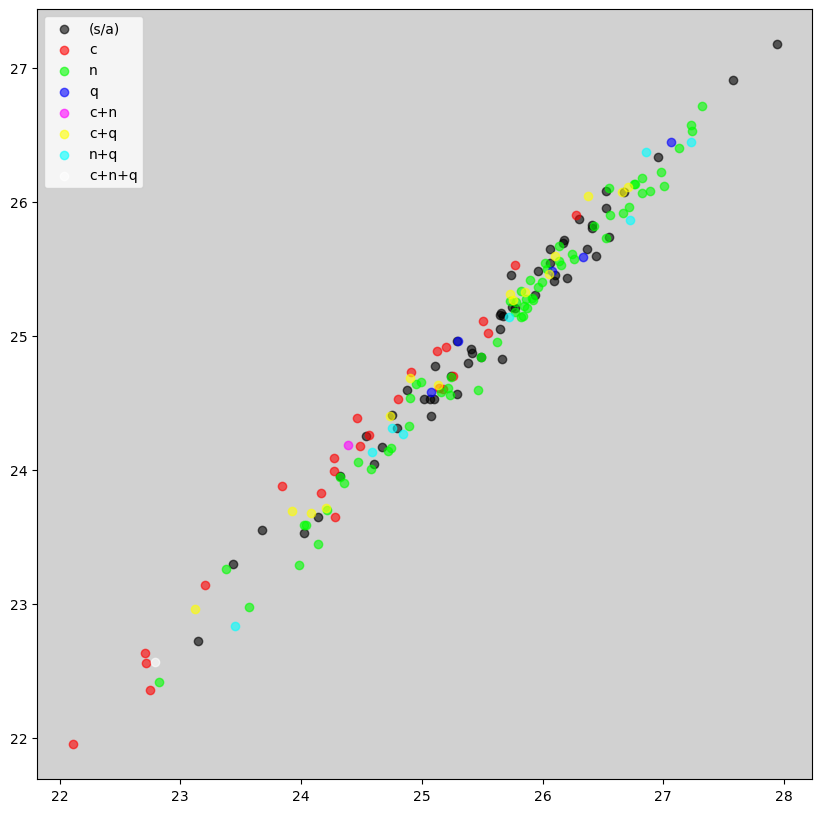

[[24.03251457 23.88080978]
 [23.2672081  22.90708542]
 [26.33939743 25.58546638]
 [25.52451706 25.18828201]
 [22.50936508 22.46112442]
 [26.33618927 25.82351112]
 [26.93133736 26.38841248]
 [25.62906456 25.04417992]
 [24.95439339 24.50483894]
 [25.97970581 25.28126907]
 [25.23282242 24.66426849]
 [25.2748127  24.73939896]
 [26.57667923 25.89448357]
 [26.25199699 25.67892265]
 [26.70694542 25.89815903]
 [27.46122742 26.77496338]
 [25.10147476 24.56113625]
 [26.68406296 25.95456314]
 [25.39105988 25.07544708]
 [25.43910217 24.78720093]
 [26.93888855 26.16539764]
 [25.60997009 24.9601326 ]
 [24.29460907 23.81998825]
 [25.61657715 25.16043472]
 [25.99587059 25.47702217]
 [25.86980057 25.30466843]
 [24.71506691 24.29281235]
 [22.61792374 22.3158226 ]
 [24.92297173 24.43992996]
 [25.96146584 25.34912491]
 [23.52768707 23.30459785]
 [25.33485794 24.87445831]
 [24.6967659  24.3541069 ]
 [27.08348465 26.62282944]
 [25.5687294  24.96621323]
 [25.47882271 25.04744911]
 [23.25378609 23.03238678]
 

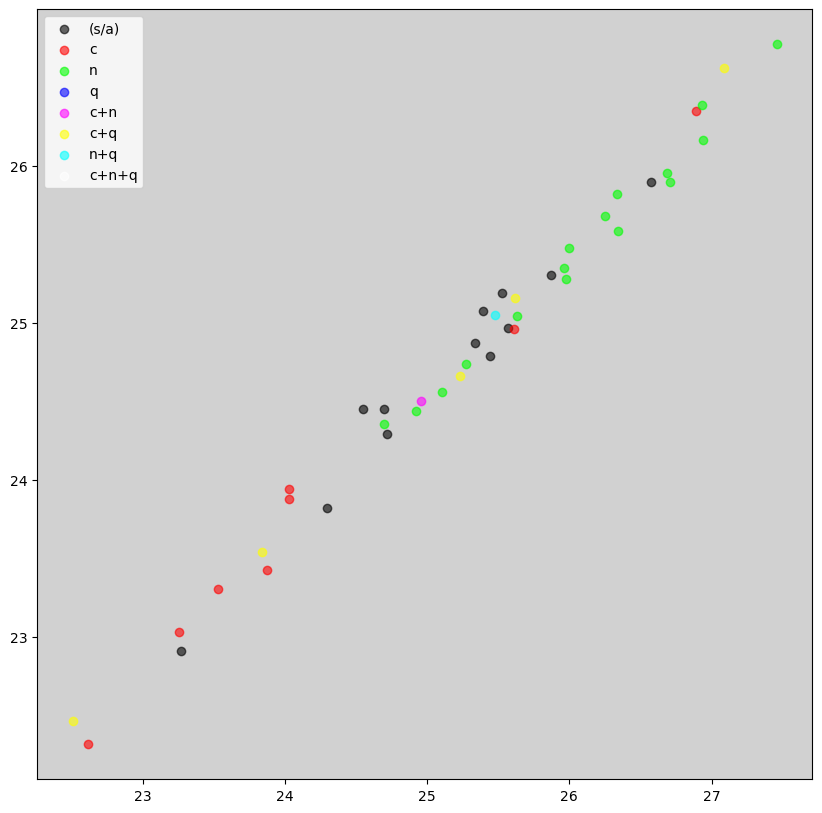

In [6]:
plt.close()
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

In [29]:
from datasets import ProximityCTTripletDataset
from torch.utils.data import random_split, DataLoader

import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np

cuda = torch.cuda.is_available()

'''
# Set up the network and training parameters
from networks import CTEmbeddingModel, EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = CTEmbeddingModel()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 1
'''
#---------------------------------------------------------------------------



# Set up data loaders
training_split_ratio = 0.7

subject_list = [dirname for dirname in os.listdir(DR217_CT_PATH)]

num_subjects = len(subject_list)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = (num_training_subjects, num_validation_subjects)

training_subjects, validation_subjects = torch.utils.data.random_split(subject_list, num_split_subjects)

#triplet_dataset = ProximityCTTripletDataset(DR217_CT_PATH, subject_list, DR217_LABELS_PATH, train=True)
triplet_training_set = ProximityCTTripletDataset(DR217_CT_PATH, training_subjects, DR217_LABELS_PATH, train=True)
triplet_validation_set = ProximityCTTripletDataset(DR217_CT_PATH, validation_subjects, DR217_LABELS_PATH, train=False)

print('Training set size:', len(triplet_training_set))
print('Validation set size:', len(triplet_validation_set))

def collate(batch):
    data = []
    labels = []
    for s in batch:
        data.append(s['t1']['data'].squeeze(0))
        labels.append(s['labels_as_vector'])
    return torch.stack(data), torch.tensor(labels, dtype=torch.float32)

# Set up data loaders
n_classes = 3
batch_size = 4
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_training_set, batch_size=batch_size, shuffle=True, collate_fn=None, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_validation_set, batch_size=batch_size, shuffle=False, collate_fn=None, **kwargs)

# Set up the network and training parameters
from networks import CTEmbeddingModel, EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = CTEmbeddingModel()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 1

Training set size: 148
Validation set size: 65


In [5]:
from datasets import ProximityCTEmbeddingDataset
from torch.utils.data import random_split, DataLoader

import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import default_collate

from trainer import fit
import numpy as np

import random
from pathlib import Path

cuda = torch.cuda.is_available()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Set up data loaders
training_split_ratio = 0.7

embeddings_files_list = sorted(Path(DR217_RESNET_EMBEDDINGS_PATH).glob('*.npz'))


num_subjects = len(embeddings_files_list)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_data = (num_training_subjects, num_validation_subjects)

training_data_paths, validation_data_paths = torch.utils.data.random_split(embeddings_files_list, num_split_data)

triplet_training_set = ProximityCTEmbeddingDataset(training_data_paths)
triplet_validation_set = ProximityCTEmbeddingDataset(validation_data_paths)

print('Training set size:', len(triplet_training_set))
print('Validation set size:', len(triplet_validation_set))

def collate(batch):
    batch = list(filter(lambda x:x is not None, batch))
    return default_collate(batch)

# Set up data loaders
n_classes = 3
batch_size = 17
kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_training_set, batch_size=batch_size, shuffle=True, collate_fn=collate, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate, **kwargs)

# Set up the network and training parameters
from networks import CTPreEmbeddedModel, TripletNet
from losses import OnlineTripletLoss
from utils import HardestNegativeTripletSelector
from metrics import AverageNonzeroTripletsMetric

margin = 0.2
embedding_net = CTPreEmbeddedModel(embedding_size=128)
model = embedding_net
if cuda:
    model.cuda()
    
loss_fn = OnlineTripletLoss(margin, HardestNegativeTripletSelector(margin))
lr = 5e-5
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 50, gamma=0.1, last_epoch=-1)
n_epochs = 100
log_interval = 4

Training set size: 149
Validation set size: 64


In [10]:
fit(
    triplet_train_loader, 
    triplet_test_loader, 
    model, 
    loss_fn, 
    optimizer, 
    scheduler, 
    n_epochs, 
    cuda, 
    log_interval,
    TRIPLET_CHECKPOINTS_PATH,
    metrics=[AverageNonzeroTripletsMetric()]
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100. Train set:
	Average loss: 0.2180
Average nonzero triplets:
0.22099825739860535
Epoch: 1/100. Validation set:
	Average loss: 0.2004
Average nonzero triplets:
0.2002514749765396
Best validation loss reached!: 0.2004. Saving model checkpoint...
Epoch: 2/100. Train set:
	Average loss: 0.2183
Average nonzero triplets:
0.21367228031158447
Epoch: 2/100. Validation set:
	Average loss: 0.2004
Average nonzero triplets:
0.2002616822719574
Epoch: 3/100. Train set:
	Average loss: 0.2166
Average nonzero triplets:
0.21523450314998627
Epoch: 3/100. Validation set:
	Average loss: 0.2004
Average nonzero triplets:
0.2002713680267334
Epoch: 4/100. Train set:
	Average loss: 0.2167
Average nonzero triplets:
0.21962282061576843
Epoch: 4/100. Validation set:
	Average loss: 0.2005
Average nonzero triplets:
0.20047909021377563
triplets[:10]: tensor([[ 3,  8,  0],
        [ 3, 12,  0],
        [ 8,  3, 11],
        [ 8, 12, 11],
        [12,  3,  1],
        [12,  8,  1],
        [ 0,  6,  3],
    

In [6]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

  0%|          | 0/100 [00:00<?, ?it/s]

an_sims: tensor([0.8525, 0.8525, 0.8525, 0.8525, 0.8525, 0.8525, 0.8442, 0.8442, 0.8442,
        0.8442, 0.8442, 0.8442, 0.8394, 0.8394, 0.8394, 0.8394, 0.8394, 0.8394,
        0.8411, 0.8411, 0.8411, 0.8411, 0.8411, 0.8411, 0.8631, 0.8631, 0.8631,
        0.8631, 0.8631, 0.8631, 0.8547, 0.8547, 0.8547, 0.8547, 0.8547, 0.8547,
        0.8307, 0.8307, 0.8307, 0.8307, 0.8307, 0.8307, 0.7797, 0.7797, 0.7797,
        0.7797, 0.7797, 0.7797, 0.8411, 0.8411, 0.8411, 0.8411, 0.8411, 0.8411,
        0.8730, 0.8730, 0.8730, 0.8730, 0.8730, 0.8730, 0.8442, 0.8442, 0.8442,
        0.8442, 0.8442, 0.8442, 0.8254, 0.8254, 0.8254, 0.8254, 0.8254, 0.8254,
        0.8591, 0.8591, 0.8591, 0.8591, 0.8591, 0.8591, 0.8394, 0.8394, 0.8394,
        0.8394, 0.8394, 0.8394], device='cuda:0', grad_fn=<SumBackward1>)
ap_sims: tensor([0.7235, 0.8116, 0.7666, 0.7858, 0.8011, 0.7758, 0.7235, 0.8387, 0.7937,
        0.7892, 0.8326, 0.7612, 0.8116, 0.8387, 0.8338, 0.8365, 0.8644, 0.7550,
        0.7666, 0.7937, 0.83

KeyboardInterrupt: 

In [6]:
#d, _ = next(iter(triplet_train_loader))
#print(np.array(d).shape)

(3, 8, 100, 512, 10, 10)


In [7]:
from itertools import combinations, permutations

l = [0, 1, 2]

print(list(combinations(l, 2)))
print(list(permutations(l, 2)))

[(0, 1), (0, 2), (1, 2)]
[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]


[[ 0.11317223 -0.16716824]
 [ 0.20475034 -0.12173837]
 [ 0.05569943 -0.17734973]
 [-0.03302989 -0.21763885]
 [ 0.06654175 -0.18052816]
 [-0.0134169  -0.22721861]
 [-0.01104631 -0.21573804]
 [ 0.05956627 -0.2015375 ]
 [ 0.01888748 -0.1998755 ]
 [ 0.03617366 -0.21500488]
 [ 0.10647564 -0.1779833 ]
 [-0.0039866  -0.2286972 ]
 [ 0.15286426 -0.14936231]
 [ 0.11860379 -0.14405811]
 [-0.02368006 -0.23450692]
 [-0.01156207 -0.21772595]
 [-0.01295508 -0.21586229]
 [-0.01624349 -0.21919285]
 [ 0.17074077 -0.14198866]
 [ 0.11800785 -0.17019895]
 [-0.02126092 -0.23170774]
 [-0.02413352 -0.22070535]
 [ 0.1445476  -0.14751476]
 [-0.02465936 -0.21826975]
 [ 0.1911613  -0.12903531]
 [-0.02680727 -0.22870687]
 [ 0.0046328  -0.22237542]
 [ 0.08944639 -0.15735479]
 [ 0.12439566 -0.12677935]
 [ 0.1280102  -0.17463446]
 [ 0.19754526 -0.14014673]
 [ 0.11265411 -0.19102745]
 [-0.03589389 -0.24042726]
 [ 0.12451076 -0.18254466]
 [ 0.09645898 -0.17162268]
 [-0.01072673 -0.21671277]
 [ 0.02652429 -0.20574272]
 

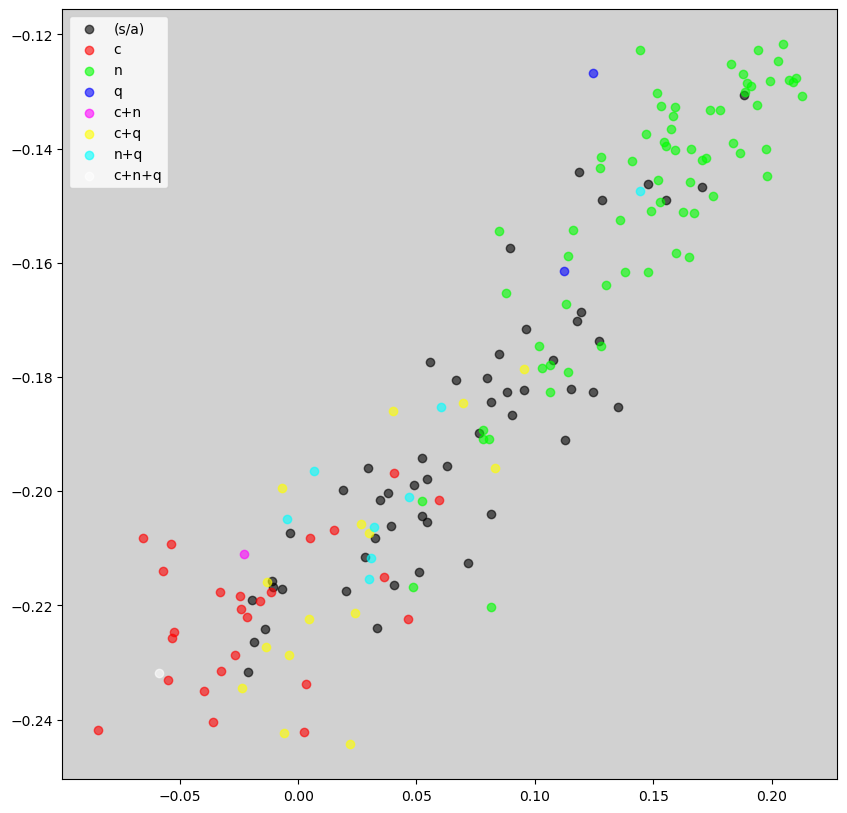

[[ 0.05115901 -0.18896312]
 [-0.04091443 -0.23232447]
 [ 0.09946547 -0.1922759 ]
 [ 0.07543458 -0.18130502]
 [-0.0439571  -0.22701897]
 [ 0.12436885 -0.16336742]
 [ 0.18057193 -0.15030482]
 [ 0.13393936 -0.14201577]
 [ 0.11985528 -0.16409977]
 [ 0.05349217 -0.19380392]
 [ 0.12122117 -0.15770242]
 [ 0.17888671 -0.1328184 ]
 [ 0.05443807 -0.22220583]
 [ 0.05251984 -0.22180939]
 [ 0.13906741 -0.15262818]
 [ 0.0237571  -0.19823129]
 [-0.02629992 -0.24183442]
 [ 0.13747753 -0.16747852]
 [ 0.1164047  -0.18205141]
 [ 0.05621284 -0.18386163]
 [ 0.05759224 -0.18574511]
 [ 0.06566795 -0.19116981]
 [ 0.0197468  -0.22127539]
 [ 0.01636259 -0.22075011]
 [ 0.15637411 -0.15462168]
 [-0.00900456 -0.21887748]
 [ 0.09339864 -0.17881574]
 [ 0.06936958 -0.1849363 ]
 [ 0.01714293 -0.19773951]
 [-0.0522129  -0.23891123]
 [ 0.10864349 -0.18478498]
 [ 0.14396484 -0.17100418]
 [-0.04270308 -0.23581913]
 [ 0.11963981 -0.16442634]
 [-0.04753439 -0.24694017]
 [ 0.05618205 -0.18289952]
 [ 0.10289048 -0.169819  ]
 

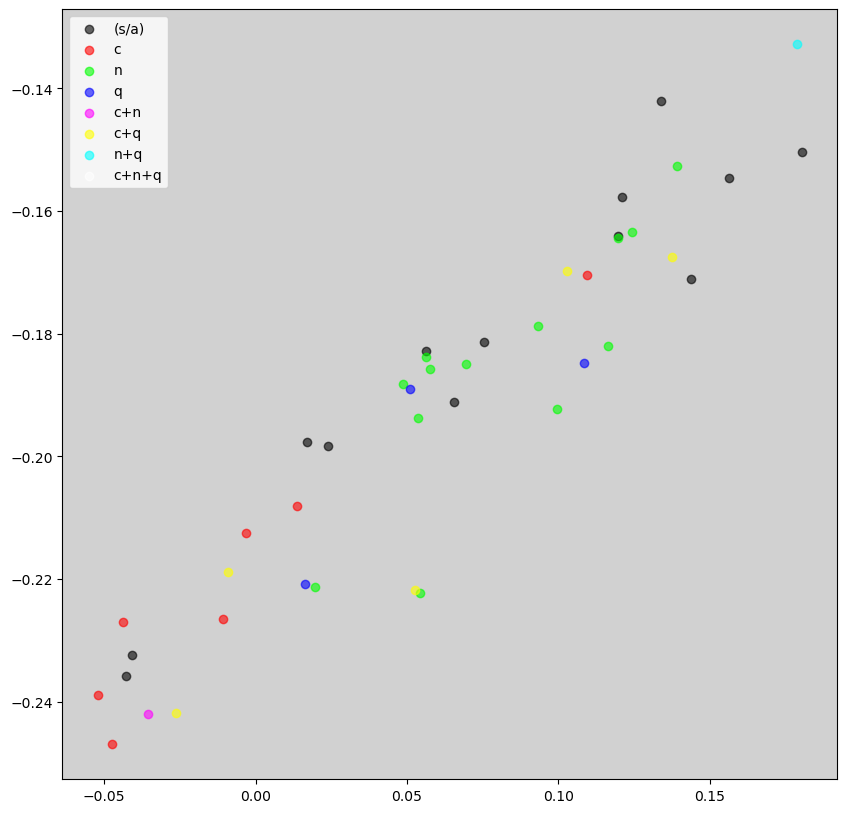

In [6]:
from datasets import ProximityCTEmbeddingDataset

training_set = ProximityCTEmbeddingDataset(training_data_paths, train=True)
validation_set = ProximityCTEmbeddingDataset(validation_data_paths, train=False)

kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, collate_fn=collate, **kwargs)
test_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, collate_fn=collate, **kwargs)

train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [13]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [14]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.491550
Train: [12500/60000 (21%)]	Loss: 0.270060
Train: [25000/60000 (42%)]	Loss: 0.139297
Train: [37500/60000 (62%)]	Loss: 0.096533
Train: [50000/60000 (83%)]	Loss: 0.076680
Epoch: 1/20. Train set: Average loss: 0.1338
Epoch: 1/20. Validation set: Average loss: 0.0537
Train: [0/60000 (0%)]	Loss: 0.052101
Train: [12500/60000 (21%)]	Loss: 0.052579
Train: [25000/60000 (42%)]	Loss: 0.047850
Train: [37500/60000 (62%)]	Loss: 0.037767
Train: [50000/60000 (83%)]	Loss: 0.037061
Epoch: 2/20. Train set: Average loss: 0.0418
Epoch: 2/20. Validation set: Average loss: 0.0325
Train: [0/60000 (0%)]	Loss: 0.015191
Train: [12500/60000 (21%)]	Loss: 0.027951
Train: [25000/60000 (42%)]	Loss: 0.025129
Train: [37500/60000 (62%)]	Loss: 0.026858
Train: [50000/60000 (83%)]	Loss: 0.024246
Epoch: 3/20. Train set: Average loss: 0.0254
Epoch: 3/20. Validation set: Average loss: 0.0274
Train: [0/60000 (0%)]	Loss: 0.010963
Train: [12500/60000 (21%)]	Loss: 0.019170
Train: [25000/60000 (

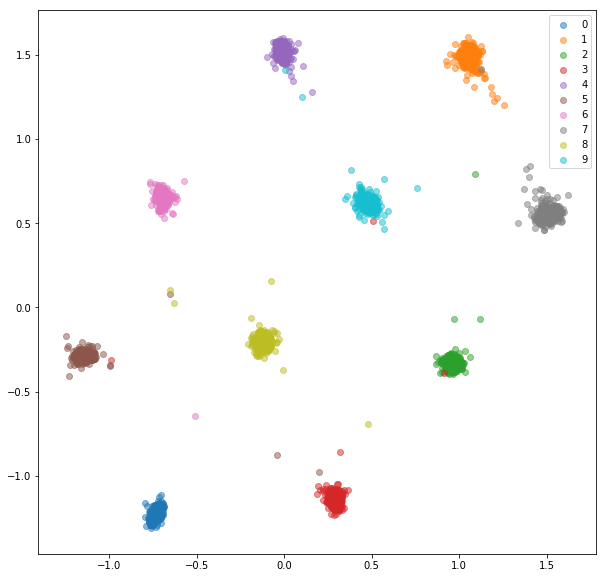

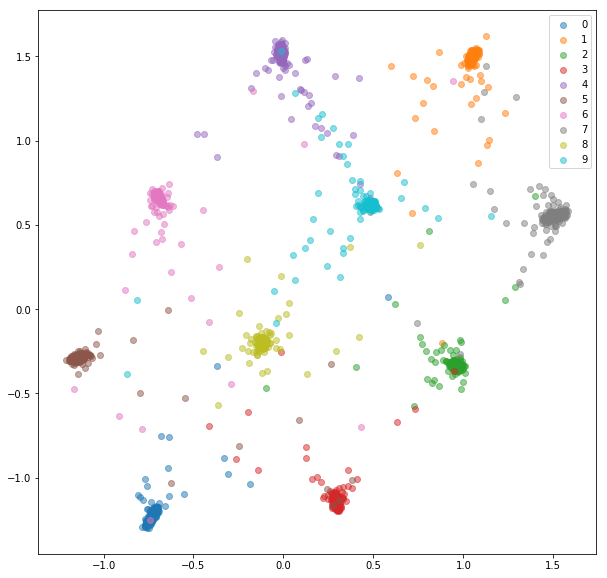

In [15]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [16]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [17]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999806	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.989613	Average nonzero triplets: 2648.725490196078
Train: [25000/60000 (42%)]	Loss: 0.994085	Average nonzero triplets: 2328.5346534653463
Train: [37500/60000 (62%)]	Loss: 0.958655	Average nonzero triplets: 2115.5165562913908
Train: [50000/60000 (83%)]	Loss: 0.976330	Average nonzero triplets: 1921.4925373134329
Epoch: 1/20. Train set: Average loss: 0.9805	Average nonzero triplets: 1801.7071129707113
Epoch: 1/20. Validation set: Average loss: 0.8326	Average nonzero triplets: 1218.6410256410256
Train: [0/60000 (0%)]	Loss: 0.876484	Average nonzero triplets: 1217.0
Train: [12500/60000 (21%)]	Loss: 0.991039	Average nonzero triplets: 975.3529411764706
Train: [25000/60000 (42%)]	Loss: 0.992353	Average nonzero triplets: 934.009900990099
Train: [37500/60000 (62%)]	Loss: 1.075175	Average nonzero triplets: 917.0596026490066
Train: [50000/60000 (83%)]	Loss: 1.023091	Average nonzero triplets: 889

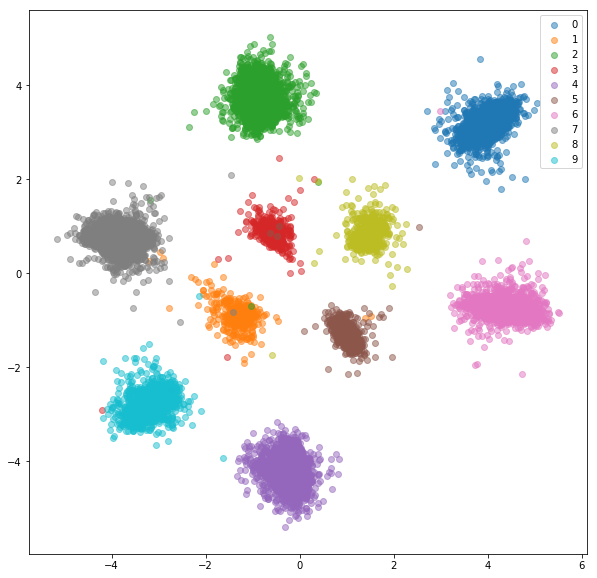

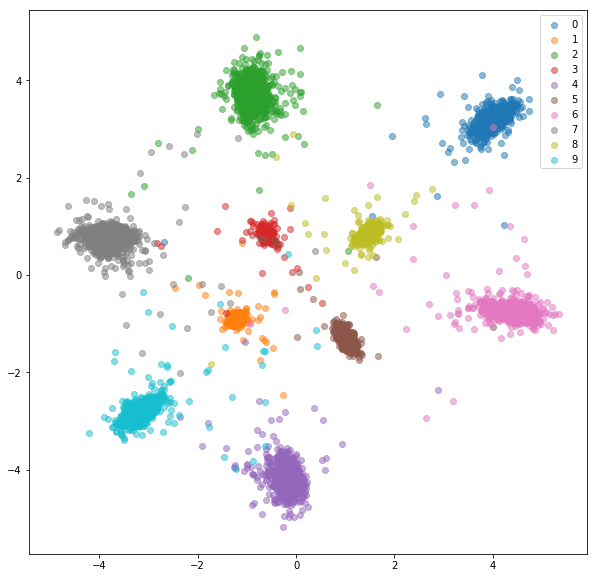

In [18]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

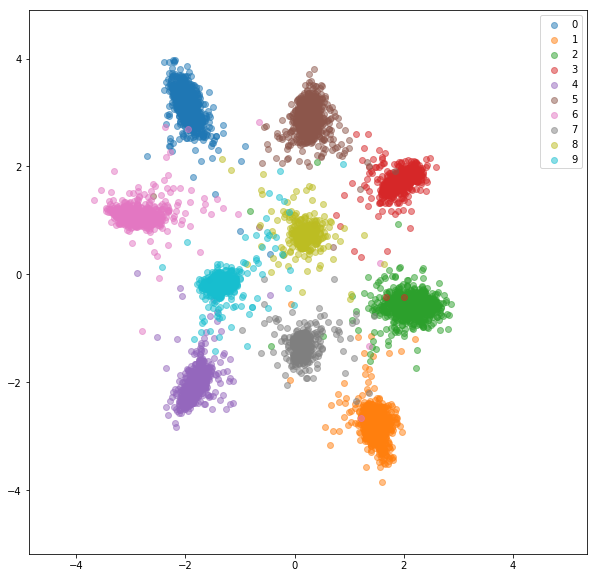

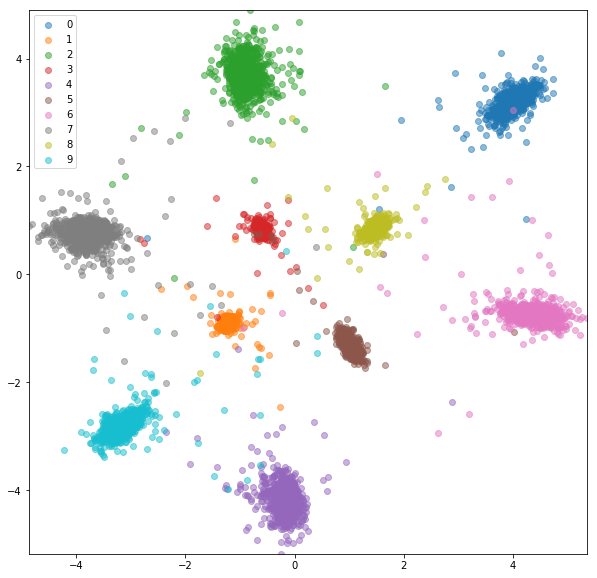

In [19]:
# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

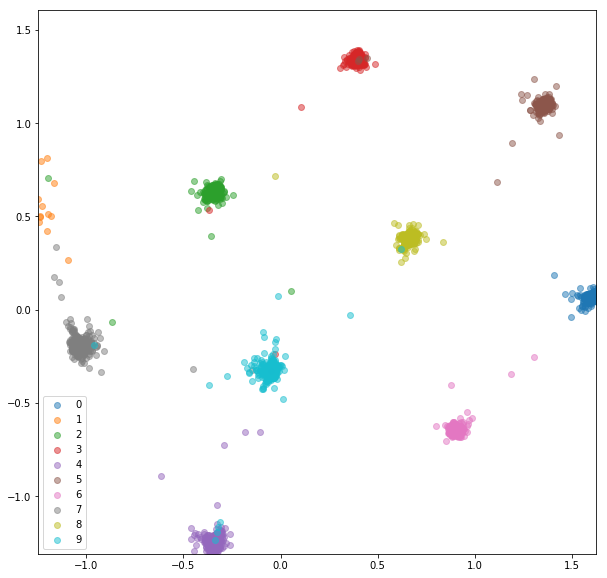

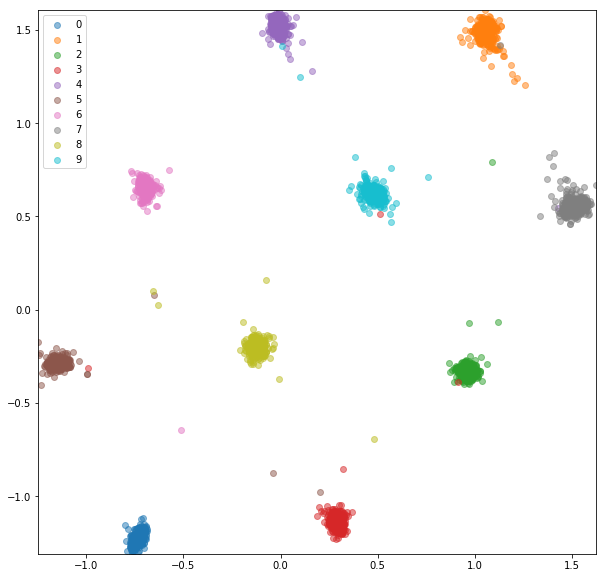

In [20]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.386014	Accuracy: 10.546875
Train: [12800/60000 (21%)]	Loss: 3.229439	Accuracy: 14.46844362745098
Train: [25600/60000 (43%)]	Loss: 1.495325	Accuracy: 26.106126237623762
Train: [38400/60000 (64%)]	Loss: 0.845725	Accuracy: 40.54480546357616
Train: [51200/60000 (85%)]	Loss: 0.454127	Accuracy: 52.90733830845771
Epoch: 1/20. Train set: Average loss: 1.3398	Accuracy: 58.565
Epoch: 1/20. Validation set: Average loss: 0.3288	Accuracy: 92.12
Train: [0/60000 (0%)]	Loss: 0.248463	Accuracy: 93.75
Train: [12800/60000 (21%)]	Loss: 0.266778	Accuracy: 94.00275735294117
Train: [25600/60000 (43%)]	Loss: 0.208191	Accuracy: 94.84839108910892
Train: [38400/60000 (64%)]	Loss: 0.236756	Accuracy: 94.91928807947019
Train: [51200/60000 (85%)]	Loss: 0.173370	Accuracy: 95.28723569651741
Epoch: 2/20. Train set: Average loss: 0.2107	Accuracy: 95.54833333333333
Epoch: 2/20. Validation set: Average loss: 0.1537	Accuracy: 97.21
Train: [0/60000 (0%)]	Loss: 0.235131	Accuracy: 95.703125
Train

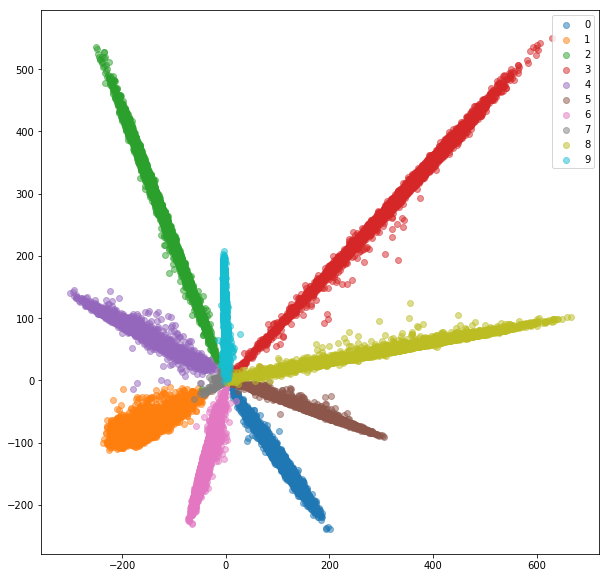

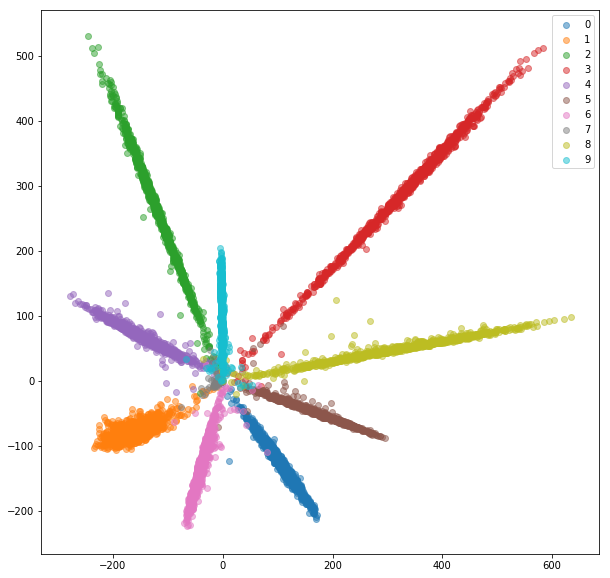

In [6]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [7]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [8]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.227718
Train: [12800/60000 (21%)]	Loss: 0.072131
Train: [25600/60000 (43%)]	Loss: 0.040934
Train: [38400/60000 (64%)]	Loss: 0.031564
Train: [51200/60000 (85%)]	Loss: 0.025739
Epoch: 1/20. Train set: Average loss: 0.0400
Epoch: 1/20. Validation set: Average loss: 0.0192
Train: [0/60000 (0%)]	Loss: 0.011247
Train: [12800/60000 (21%)]	Loss: 0.018377
Train: [25600/60000 (43%)]	Loss: 0.016195
Train: [38400/60000 (64%)]	Loss: 0.014791
Train: [51200/60000 (85%)]	Loss: 0.012396
Epoch: 2/20. Train set: Average loss: 0.0149
Epoch: 2/20. Validation set: Average loss: 0.0125
Train: [0/60000 (0%)]	Loss: 0.013657
Train: [12800/60000 (21%)]	Loss: 0.010621
Train: [25600/60000 (43%)]	Loss: 0.011142
Train: [38400/60000 (64%)]	Loss: 0.009533
Train: [51200/60000 (85%)]	Loss: 0.007959
Epoch: 3/20. Train set: Average loss: 0.0096
Epoch: 3/20. Validation set: Average loss: 0.0083
Train: [0/60000 (0%)]	Loss: 0.003296
Train: [12800/60000 (21%)]	Loss: 0.006550
Train: [25600/60000 (

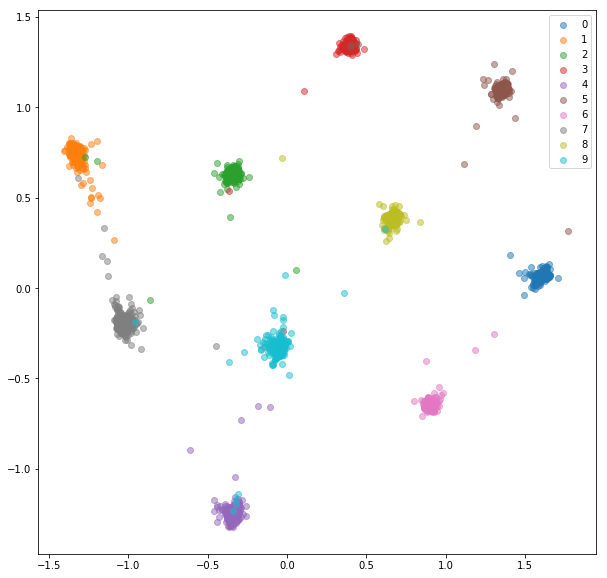

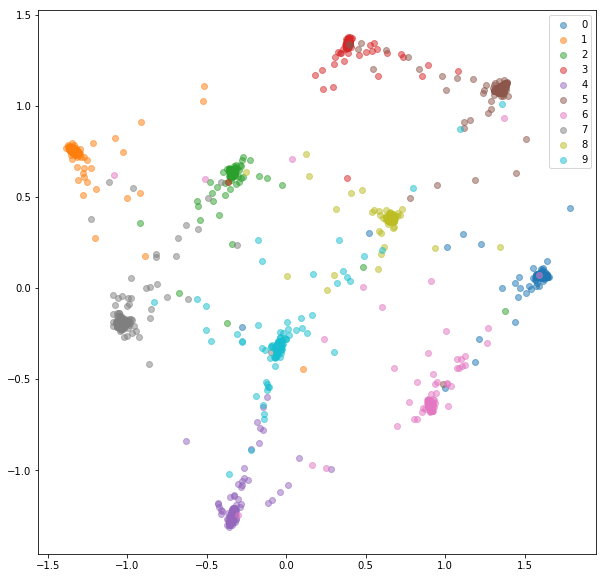

In [9]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)